# Part 1: Topic Classification

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
from collections import Counter
from itertools import product
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
NLTK_AVAILABLE = True

plt.style.use('default')
sns.set_palette("husl")
print("Environment setup complete")
# Load the dataset
df = pd.read_csv('dataset.tsv', sep='\t')

print("Dataset Overview:")
print(f"Shape: {df.shape}")
print(f"Columns: {list(df.columns)}")

print("\nTopic Distribution:")
topic_counts = df['topic'].value_counts()
print(topic_counts)

print(f"\nAverage lyrics length: {df['lyrics'].str.len().mean():.1f} characters")
print(f"Average word count: {df['lyrics'].str.split().str.len().mean():.1f} words")
# Basic text statistics for understanding the dataset characteristics
df['lyrics_length'] = df['lyrics'].str.len()
df['word_count'] = df['lyrics'].str.split().str.len()

print(f"Text Statistics Summary:")
print(f"Min/Max word count: {df['word_count'].min()}/{df['word_count'].max()}")
print(f"Standard deviation: {df['word_count'].std():.1f} words")

Environment setup complete
Dataset Overview:
Shape: (1500, 6)
Columns: ['artist_name', 'track_name', 'release_date', 'genre', 'lyrics', 'topic']

Topic Distribution:
topic
dark         490
sadness      376
personal     347
lifestyle    205
emotion       82
Name: count, dtype: int64

Average lyrics length: 472.2 characters
Average word count: 77.3 words
Text Statistics Summary:
Min/Max word count: 1/197
Standard deviation: 38.9 words


## Question 1

### Probelm 1: the regex might remove too many special characters
To prevent removing too many meaningful characters, I'm going adjust the default removed characters to a gentaler and wide regular expression, which will keep the emotional character or structural character such as "!" "?" "'". Further, the tokenlization will be applied to prevent over-fitting problem.

### Problem 2: the evaluation is based on only one trainingtest split rather than using cross-validation

Compare with using single train-test split set, I applied K-fold cross-validation by using scikit-learn's StratifiedKFold. This method evaluates the proformance by using multiple data part and reports the average metrics, so that the robustness will be enhanced and the generalization performace will be more stable. Moreover, this method will reduce the risk of performance distortion caused by some particular unblanced data spliting.

### Changes: All changes in the code will be mentioned in Question 2.

## Question 2: MNB&BNB with different preprocessing steps

### Preprocessing Comprasion Design::
1. **Special Character Handling**: Keep the emotional character vs Remove all non-alphabetic character
2. **Tokenizer**: NLTK word_tokenize vs split based on whitespace
3. **Stopword**: NLTK English list vs scikit-learn's default stopword list vs not removing stopwords
4. **Lowercasing**: True vs False
5. **Stemming/Lemmatization**: PorterStemmer vs WordNetLemmatizer vs no normalization

In [2]:
# initialize the preprocessing parameters
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()
nltk_stopwords = set(stopwords.words('english'))
    
def preprocess_text(text, config):

    if not isinstance(text, str):
        return ""
    
    # Lowercasing
    if config['lowercase']:
        text = text.lower()
    
    # Special character handling
    if config['special_chars'] == 'preserve_emotional':
        # Keep emotional symbols
        text = re.sub(r'[^\w\s!?\'\-]', ' ', text)
    elif config['special_chars'] == 'remove_all':
        # Remove all non-alphabetical characters
        text = re.sub(r'[^a-zA-Z\s]', ' ', text)
    
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    # Tokenization
    if config['tokenizer'] == 'nltk' and NLTK_AVAILABLE:
        tokens = word_tokenize(text)
    else:
        # Split based on whitespace
        tokens = text.split()
    
    # Stopword removal
    if config['stopwords'] == 'nltk' and NLTK_AVAILABLE:
        tokens = [token for token in tokens if token.lower() not in nltk_stopwords]
    elif config['stopwords'] == 'sklearn':
        # Will be handled using CountVectorizer
        pass
    # If 'none', skip stopword removal
    
    # Normalization: stemming or lemmatization
    if config['normalization'] == 'stemming' and NLTK_AVAILABLE:
        tokens = [stemmer.stem(token) for token in tokens]
    elif config['normalization'] == 'lemmatization' and NLTK_AVAILABLE:
        tokens = [lemmatizer.lemmatize(token) for token in tokens]
    
    return ' '.join(tokens)

def comprehensive_preprocessing_experiment(df, max_features=500, cv_folds=5):

    # Define combinations of preprocessing configurations
    param_combinations = [
        # Basic configurations
        {'special_chars': 'preserve_emotional', 'tokenizer': 'sklearn', 'stopwords': 'sklearn', 
         'lowercase': True, 'normalization': 'none'},
        {'special_chars': 'remove_all', 'tokenizer': 'sklearn', 'stopwords': 'sklearn', 
         'lowercase': True, 'normalization': 'none'},
        
        # Different stopword sources
        {'special_chars': 'preserve_emotional', 'tokenizer': 'nltk', 'stopwords': 'nltk', 
         'lowercase': True, 'normalization': 'none'},
        {'special_chars': 'preserve_emotional', 'tokenizer': 'sklearn', 'stopwords': 'none', 
         'lowercase': True, 'normalization': 'none'},
        
        # Stemming and lemmatization
        {'special_chars': 'preserve_emotional', 'tokenizer': 'nltk', 'stopwords': 'nltk', 
         'lowercase': True, 'normalization': 'stemming'},
        {'special_chars': 'preserve_emotional', 'tokenizer': 'nltk', 'stopwords': 'nltk', 
         'lowercase': True, 'normalization': 'lemmatization'},
        
        # Uppercase vs lowercase
        {'special_chars': 'preserve_emotional', 'tokenizer': 'sklearn', 'stopwords': 'sklearn', 
         'lowercase': False, 'normalization': 'none'},
        
        # Combined optimized configurations
        {'special_chars': 'preserve_emotional', 'tokenizer': 'nltk', 'stopwords': 'sklearn', 
         'lowercase': True, 'normalization': 'lemmatization'},
        {'special_chars': 'remove_all', 'tokenizer': 'nltk', 'stopwords': 'nltk', 
         'lowercase': True, 'normalization': 'stemming'},
    ]
    
    results = []
    
    print("Starting systematic preprocessing experiment")
    print("=" * 80)
    
    for i, config in enumerate(param_combinations):
        print(f"\nConfiguration {i+1}/{len(param_combinations)}:")
        config_str = f"Special Chars: {config['special_chars'][:8]}, Tokenizer: {config['tokenizer']}, " \
                     f"Stopwords: {config['stopwords']}, Lowercase: {config['lowercase']}, " \
                     f"Normalization: {config['normalization']}"
        print(f"Config: {config_str}")
        print("-" * 60)

        # Apply preprocessing
        processed_texts = df['lyrics'].apply(lambda x: preprocess_text(x, config))
        
        # Feature extraction
        stop_words_param = 'english' if config['stopwords'] == 'sklearn' else None
        vectorizer = CountVectorizer(max_features=max_features, stop_words=stop_words_param)
        
        try:
            X = vectorizer.fit_transform(processed_texts)
            y = df['topic']
            
            # Cross-validation setup
            skf = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)
            
            # BNB Evaluation
            bnb = BernoulliNB()
            bnb_acc = cross_val_score(bnb, X, y, cv=skf, scoring='accuracy').mean()
            bnb_f1 = cross_val_score(bnb, X, y, cv=skf, scoring='f1_macro').mean()
            bnb_prec = cross_val_score(bnb, X, y, cv=skf, scoring='precision_macro').mean()
            bnb_recall = cross_val_score(bnb, X, y, cv=skf, scoring='recall_macro').mean()

            # MNB Evaluation
            mnb = MultinomialNB()
            mnb_acc = cross_val_score(mnb, X, y, cv=skf, scoring='accuracy').mean()
            mnb_f1 = cross_val_score(mnb, X, y, cv=skf, scoring='f1_macro').mean()
            mnb_prec = cross_val_score(mnb, X, y, cv=skf, scoring='precision_macro').mean()
            mnb_recall = cross_val_score(mnb, X, y, cv=skf, scoring='recall_macro').mean()

            print(f"BNB - Accuracy: {bnb_acc:.4f}, F1: {bnb_f1:.4f}, Precision: {bnb_prec:.4f}, Recall: {bnb_recall:.4f}")
            print(f"MNB - Accuracy: {mnb_acc:.4f}, F1: {mnb_f1:.4f}, Precision: {mnb_prec:.4f}, Recall: {mnb_recall:.4f}")

            # Store result
            result = {
                'config_id': i+1,
                'config': config.copy(),
                'config_str': config_str,
                'bnb_accuracy': bnb_acc,
                'bnb_f1': bnb_f1,
                'bnb_precision': bnb_prec,
                'bnb_recall': bnb_recall,
                'mnb_accuracy': mnb_acc,
                'mnb_f1': mnb_f1,
                'mnb_precision': mnb_prec,
                'mnb_recall': mnb_recall
            }
            results.append(result)
            
        except Exception as e:
            print(f"Configuration {i+1} failed: {e}")
            continue
    
    return results

# Execute
print("Executing comprehensive preprocessing pipeline...")
all_results = comprehensive_preprocessing_experiment(df, max_features=500, cv_folds=5)


Executing comprehensive preprocessing pipeline...
Starting systematic preprocessing experiment

Configuration 1/9:
Config: Special Chars: preserve, Tokenizer: sklearn, Stopwords: sklearn, Lowercase: True, Normalization: none
------------------------------------------------------------
BNB - Accuracy: 0.6627, F1: 0.5632, Precision: 0.5729, Recall: 0.5646
MNB - Accuracy: 0.8587, F1: 0.8287, Precision: 0.8385, Recall: 0.8222

Configuration 2/9:
Config: Special Chars: remove_a, Tokenizer: sklearn, Stopwords: sklearn, Lowercase: True, Normalization: none
------------------------------------------------------------
BNB - Accuracy: 0.6600, F1: 0.5608, Precision: 0.5704, Recall: 0.5620
MNB - Accuracy: 0.8593, F1: 0.8297, Precision: 0.8400, Recall: 0.8227

Configuration 3/9:
Config: Special Chars: preserve, Tokenizer: nltk, Stopwords: nltk, Lowercase: True, Normalization: none
------------------------------------------------------------
BNB - Accuracy: 0.6713, F1: 0.5790, Precision: 0.5941, Rec

Preprocessing Results Analysis

Sorted configurations by MNB accuracy:
--------------------------------------------------------------------------------
Config  4: MNB Accuracy 0.8787, F1 0.8586
         Special Chars: preserve, Tokenizer: sklearn, Stopwords: none, Lowercase: True, Normalization: none
         BNB Accuracy: 0.6753, F1: 0.5748
         MNB Precision: 0.8689, Recall: 0.8513
         BNB Precision: 0.5909, Recall: 0.5738

Config  3: MNB Accuracy 0.8747, F1 0.8541
         Special Chars: preserve, Tokenizer: nltk, Stopwords: nltk, Lowercase: True, Normalization: none
         BNB Accuracy: 0.6713, F1: 0.5790
         MNB Precision: 0.8649, Recall: 0.8464
         BNB Precision: 0.5941, Recall: 0.5769

Config  6: MNB Accuracy 0.8680, F1 0.8471
         Special Chars: preserve, Tokenizer: nltk, Stopwords: nltk, Lowercase: True, Normalization: lemmatization
         BNB Accuracy: 0.6580, F1: 0.5659
         MNB Precision: 0.8612, Recall: 0.8377
         BNB Precision: 0.5805, 

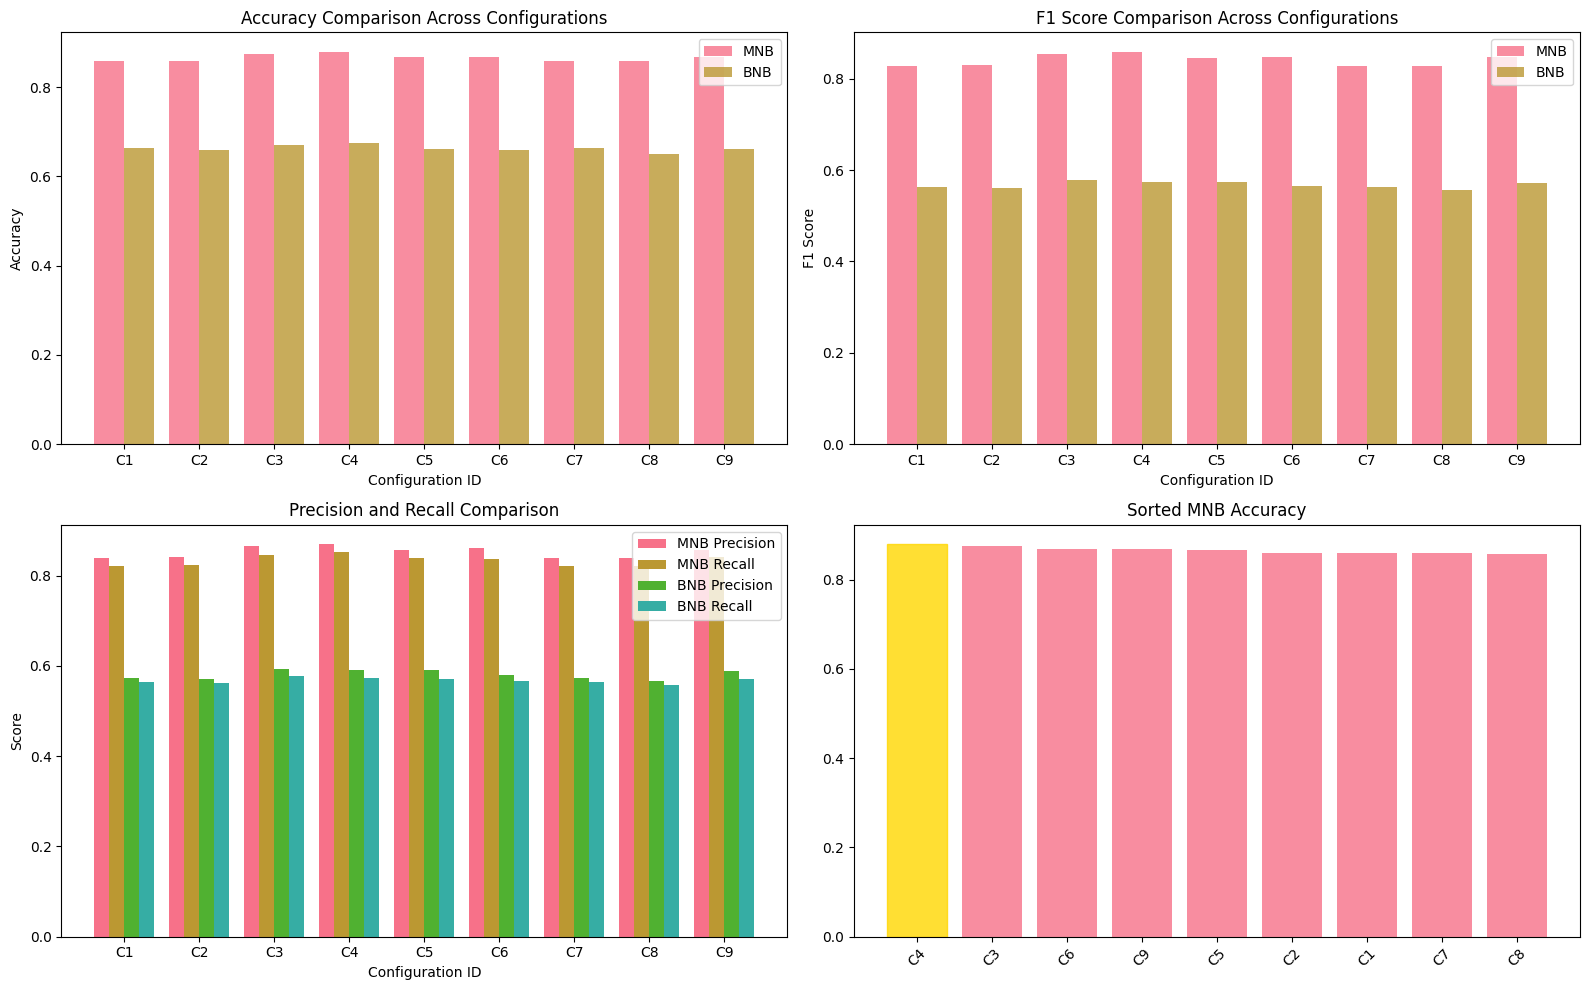

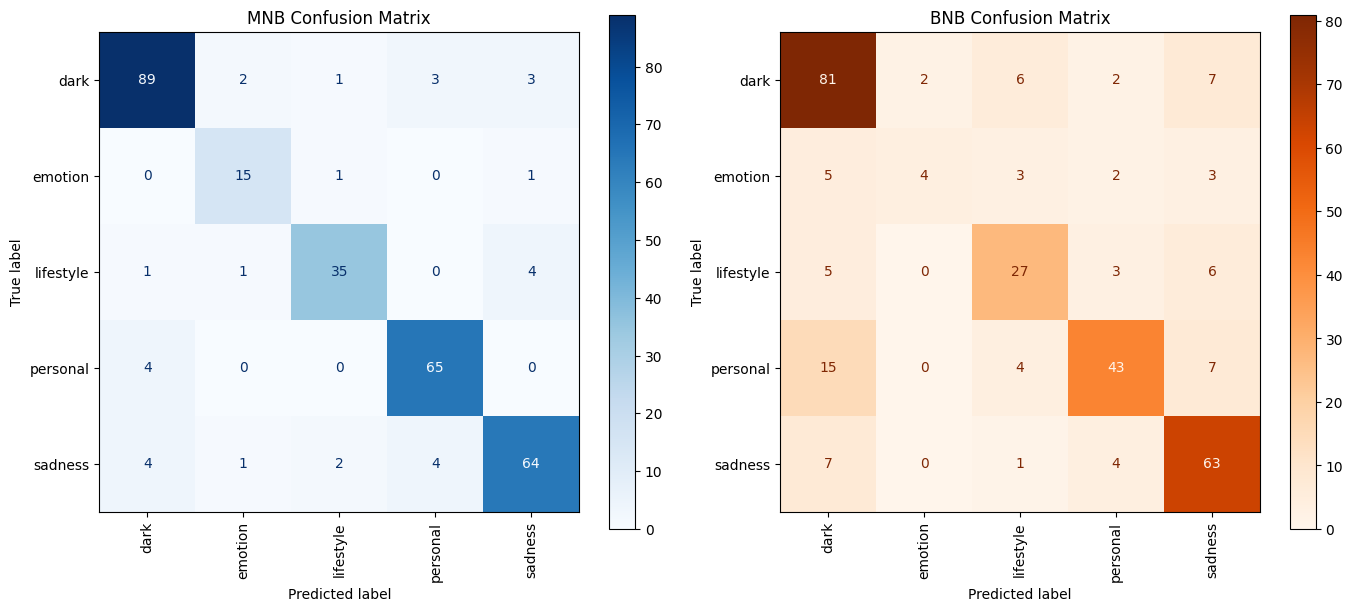


PROBLEM 2 · FINAL CONCLUSIONS AND RECOMMENDATIONS

Based on the systematic preprocessing experiments, it can be concluded that:

1. Best Preprocessing Configuration:
   - Special Character Handling: preserve_emotional
   - Tokenizer: sklearn
   - Stopword Source: none
   - Lowercasing: True
   - Normalization: none

2. Best Performance:
   - MNB Accuracy: 0.8787
   - MNB F1 Score: 0.8586
   - MNB Precision: 0.8689
   - MNB Recall: 0.8513
   - BNB Accuracy: 0.6753
   - BNB F1 Score: 0.5748
   - BNB Precision: 0.5909
   - BNB Recall: 0.5738

3. Model Recommendation:
   - Multinomial Naive Bayes significantly outperforms Bernoulli Naive Bayes
   - We recommend using MNB as the base model for subsequent experiments.


In [3]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

def plot_confusion_matrices(df, config, max_features=500):
    # Preprocess text
    processed_texts = df['lyrics'].apply(lambda x: preprocess_text(x, config))
    y = df['topic']

    # Vectorize
    stop_words_param = 'english' if config['stopwords'] == 'sklearn' else None
    vectorizer = CountVectorizer(max_features=max_features, stop_words=stop_words_param)
    X = vectorizer.fit_transform(processed_texts)

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

    fig, axes = plt.subplots(1, 2, figsize=(14, 6))  # 1 row, 2 columns

    # MNB
    mnb = MultinomialNB()
    mnb.fit(X_train, y_train)
    y_pred_mnb = mnb.predict(X_test)
    cm_mnb = confusion_matrix(y_test, y_pred_mnb, labels=sorted(y.unique()))
    disp_mnb = ConfusionMatrixDisplay(confusion_matrix=cm_mnb, display_labels=sorted(y.unique()))
    disp_mnb.plot(ax=axes[0], xticks_rotation=90, cmap='Blues')
    axes[0].set_title("MNB Confusion Matrix")

    # BNB
    bnb = BernoulliNB()
    bnb.fit(X_train, y_train)
    y_pred_bnb = bnb.predict(X_test)
    cm_bnb = confusion_matrix(y_test, y_pred_bnb, labels=sorted(y.unique()))
    disp_bnb = ConfusionMatrixDisplay(confusion_matrix=cm_bnb, display_labels=sorted(y.unique()))
    disp_bnb.plot(ax=axes[1], xticks_rotation=90, cmap='Oranges')
    axes[1].set_title("BNB Confusion Matrix")

    plt.tight_layout()
    plt.show()


# Analyze and visualize the results of systematic preprocessing experiments
def analyze_results(results):
    if not results:
        print("No experimental results available for analysis.")
        return None
    
    # Convert results to DataFrame
    results_df = pd.DataFrame(results)
    
    print("Preprocessing Results Analysis")
    print("=" * 80)
    
    # Sort configurations by MNB accuracy
    results_df_sorted = results_df.sort_values('mnb_accuracy', ascending=False)
    
    print("\nSorted configurations by MNB accuracy:")
    print("-" * 80)
    for idx, row in results_df_sorted.iterrows():
        print(f"Config {row['config_id']:2d}: MNB Accuracy {row['mnb_accuracy']:.4f}, F1 {row['mnb_f1']:.4f}")
        print(f"         {row['config_str']}")
        print(f"         BNB Accuracy: {row['bnb_accuracy']:.4f}, F1: {row['bnb_f1']:.4f}")
        print(f"         MNB Precision: {row['mnb_precision']:.4f}, Recall: {row['mnb_recall']:.4f}")
        print(f"         BNB Precision: {row['bnb_precision']:.4f}, Recall: {row['bnb_recall']:.4f}")
        print()
    
    # Best configuration
    best_config = results_df.loc[results_df['mnb_accuracy'].idxmax()]
    
    print("Best configuration (based on MNB accuracy):")
    print("-" * 40)
    print(f"Config ID: {best_config['config_id']}")
    print(f"MNB Accuracy: {best_config['mnb_accuracy']:.4f}")
    print(f"MNB F1 Score: {best_config['mnb_f1']:.4f}")
    print(f"MNB Precision: {best_config['mnb_precision']:.4f}")
    print(f"MNB Recall:    {best_config['mnb_recall']:.4f}")
    print(f"BNB Accuracy: {best_config['bnb_accuracy']:.4f}")
    print(f"BNB F1 Score: {best_config['bnb_f1']:.4f}")
    print(f"BNB Precision: {best_config['bnb_precision']:.4f}")
    print(f"BNB Recall:    {best_config['bnb_recall']:.4f}")
    print(f"Configuration: {best_config['config_str']}")
    
    return best_config, results_df


# Analyze the results and visualize
if all_results:
    best_config, results_df = analyze_results(all_results)
    
    # Visualization
    plt.figure(figsize=(16, 10))
    
    # Subplot 1: Accuracy comparison
    plt.subplot(2, 2, 1)
    x_pos = range(len(all_results))
    mnb_scores = [r['mnb_accuracy'] for r in all_results]
    bnb_scores = [r['bnb_accuracy'] for r in all_results]
    
    plt.bar([x-0.2 for x in x_pos], mnb_scores, width=0.4, label='MNB', alpha=0.8)
    plt.bar([x+0.2 for x in x_pos], bnb_scores, width=0.4, label='BNB', alpha=0.8)
    plt.xlabel('Configuration ID')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Comparison Across Configurations')
    plt.legend()
    plt.xticks(x_pos, [f'C{r["config_id"]}' for r in all_results])
    
    # Subplot 2: F1 score comparison
    plt.subplot(2, 2, 2)
    mnb_f1 = [r['mnb_f1'] for r in all_results]
    bnb_f1 = [r['bnb_f1'] for r in all_results]
    
    plt.bar([x-0.2 for x in x_pos], mnb_f1, width=0.4, label='MNB', alpha=0.8)
    plt.bar([x+0.2 for x in x_pos], bnb_f1, width=0.4, label='BNB', alpha=0.8)
    plt.xlabel('Configuration ID')
    plt.ylabel('F1 Score')
    plt.title('F1 Score Comparison Across Configurations')
    plt.legend()
    plt.xticks(x_pos, [f'C{r["config_id"]}' for r in all_results])

    # Subplot 3: Precision and Recall comparison
    plt.subplot(2, 2, 3)
    mnb_prec = [r['mnb_precision'] for r in all_results]
    bnb_prec = [r['bnb_precision'] for r in all_results]
    mnb_rec = [r['mnb_recall'] for r in all_results]
    bnb_rec = [r['bnb_recall'] for r in all_results]

    bar_width = 0.2
    index = range(len(all_results))

    plt.bar([x - 1.5*bar_width for x in index], mnb_prec, width=bar_width, label='MNB Precision')
    plt.bar([x - 0.5*bar_width for x in index], mnb_rec, width=bar_width, label='MNB Recall')
    plt.bar([x + 0.5*bar_width for x in index], bnb_prec, width=bar_width, label='BNB Precision')
    plt.bar([x + 1.5*bar_width for x in index], bnb_rec, width=bar_width, label='BNB Recall')

    plt.xlabel("Configuration ID")
    plt.ylabel("Score")
    plt.title("Precision and Recall Comparison")
    plt.xticks(index, [f"C{r['config_id']}" for r in all_results])
    plt.legend()
    # Subplot 4: Sorted MNB accuracy
    plt.subplot(2, 2, 4)
    sorted_indices = sorted(range(len(mnb_scores)), key=lambda i: mnb_scores[i], reverse=True)
    sorted_mnb = [mnb_scores[i] for i in sorted_indices]
    sorted_configs = [f'C{all_results[i]["config_id"]}' for i in sorted_indices]
    
    bars = plt.bar(range(len(sorted_mnb)), sorted_mnb, alpha=0.8)
    plt.title('Sorted MNB Accuracy')
    plt.xticks(range(len(sorted_configs)), sorted_configs, rotation=45)

    # After identifying best_config
    
    # Highlight best configuration
    bars[0].set_color('gold')
    
    plt.tight_layout()
    plt.show()
    
    plot_confusion_matrices(df, config=best_config['config'], max_features=500)
    # Final Recommendation Summary
    print("\n" + "="*80)
    print("PROBLEM 2 · FINAL CONCLUSIONS AND RECOMMENDATIONS")
    print("="*80)
    print("\nBased on the systematic preprocessing experiments, it can be concluded that:")
    print(f"\n1. Best Preprocessing Configuration:")
    print(f"   - Special Character Handling: {best_config['config']['special_chars']}")
    print(f"   - Tokenizer: {best_config['config']['tokenizer']}")
    print(f"   - Stopword Source: {best_config['config']['stopwords']}")
    print(f"   - Lowercasing: {best_config['config']['lowercase']}")
    print(f"   - Normalization: {best_config['config']['normalization']}")
    print(f"\n2. Best Performance:")
    print(f"   - MNB Accuracy: {best_config['mnb_accuracy']:.4f}")
    print(f"   - MNB F1 Score: {best_config['mnb_f1']:.4f}")
    print(f"   - MNB Precision: {best_config['mnb_precision']:.4f}")
    print(f"   - MNB Recall: {best_config['mnb_recall']:.4f}")
    print(f"   - BNB Accuracy: {best_config['bnb_accuracy']:.4f}")
    print(f"   - BNB F1 Score: {best_config['bnb_f1']:.4f}")
    print(f"   - BNB Precision: {best_config['bnb_precision']:.4f}")
    print(f"   - BNB Recall: {best_config['bnb_recall']:.4f}")
    print(f"\n3. Model Recommendation:")
    print(f"   - Multinomial Naive Bayes significantly outperforms Bernoulli Naive Bayes")
    print(f"   - We recommend using MNB as the base model for subsequent experiments.")
else:
    print("No valid results were generated from the preprocessing experiment.")


## Question 3 Compare BNB and MNB  
### Based on table and plot above
### Preprocessing
We applied Stratified 5-Fold Cross-Validation to ensure robust and balanced evaluation. And we picked 4 types of metrics, which are Accuracy,F1-Macro, Precision-Macro & Recall-Macro, compare BNB and MNB models
### Result
With analysis of the dataset, we found that there is some imbalance distribution labels, such as the number of 'emotion' songs is much more than the number of 'lifestyle' songs. To avoid misleading by accuracy, which could potentially lead to a poor performance on minority class, the marco F1-score was selected as evaluation metric. The marco F1-score gives equal weight to each class and reveals the model's overall classification performance.  
After picking the best preprocessing configuration, the performance metrics shown that the overall performance of MNB is better than BNB models in both Accuracy(0.8787 VS 0.6753) and F1-Score(0.8586 VS 0.5748). By incorporating word frequency, MNB is more responsive to distributional patterns in text, which enhances its expressiveness on natural language data like song lyrics.  
Therefore, the MNB was choosen for rest tasks

## Question 4: Feature Count Impact Analysis

Analyze how the number of features (vocabulary size) affects classification performance.

In [4]:
def preprocess_text(text):
    if not isinstance(text, str):
        return ""
    
    text = text.lower()
    text = re.sub(r'[^\w\s!?\'\-]', ' ', text) 
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def analyze_feature_count_impact(df, max_features_list=[100, 200, 300, 400, 500, 1000, None]):
    results = {
        'max_features': [],
        'actual_features': [],
        'BNB_accuracy': [], 'BNB_f1': [], 'BNB_precision': [], 'BNB_recall': [],
        'MNB_accuracy': [], 'MNB_f1': [], 'MNB_precision': [], 'MNB_recall': []
    }

    # 预处理文本
    processed_lyrics = df['lyrics'].apply(preprocess_text)
    y = df['topic']

    print("Q4: Analyzing impact of max_features...")
    for max_feat in max_features_list:
        print(f"\nTesting max_features = {max_feat if max_feat else 'all'}")
        
        vectorizer = CountVectorizer(max_features=max_feat)
        X = vectorizer.fit_transform(processed_lyrics)

        actual_features = X.shape[1]
        sparsity = 1.0 - (X.nnz / (X.shape[0] * X.shape[1]))

        # Cross-validation
        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        
        # BNB
        bnb = BernoulliNB()
        bnb_acc = cross_val_score(bnb, X, y, cv=skf, scoring='accuracy').mean()
        bnb_f1 = cross_val_score(bnb, X, y, cv=skf, scoring='f1_macro').mean()
        bnb_prec = cross_val_score(bnb, X, y, cv=skf, scoring='precision_macro').mean()
        bnb_rec = cross_val_score(bnb, X, y, cv=skf, scoring='recall_macro').mean()

        # MNB
        mnb = MultinomialNB()
        mnb_acc = cross_val_score(mnb, X, y, cv=skf, scoring='accuracy').mean()
        mnb_f1 = cross_val_score(mnb, X, y, cv=skf, scoring='f1_macro').mean()
        mnb_prec = cross_val_score(mnb, X, y, cv=skf, scoring='precision_macro').mean()
        mnb_rec = cross_val_score(mnb, X, y, cv=skf, scoring='recall_macro').mean()

        # 记录
        results['max_features'].append(max_feat if max_feat else actual_features)
        results['actual_features'].append(actual_features)

        results['BNB_accuracy'].append(bnb_acc)
        results['BNB_f1'].append(bnb_f1)
        results['BNB_precision'].append(bnb_prec)
        results['BNB_recall'].append(bnb_rec)

        results['MNB_accuracy'].append(mnb_acc)
        results['MNB_f1'].append(mnb_f1)
        results['MNB_precision'].append(mnb_prec)
        results['MNB_recall'].append(mnb_rec)

        print(f"BNB - accuracy: {bnb_acc:.4f}, F1: {bnb_f1:.4f}, precision{bnb_prec:.4f},recall{bnb_rec:.4f}")
        print(f"MNB - accuracy: {mnb_acc:.4f}, F1: {mnb_f1:.4f}, precision{mnb_prec:.4f},recall{mnb_rec:.4f}")
        print()
    return results

feature_results = analyze_feature_count_impact(df, [100, 200, 300, 400, 500, 1000, None])

Q4: Analyzing impact of max_features...

Testing max_features = 100
BNB - accuracy: 0.5920, F1: 0.5063, precision0.5288,recall0.5005
MNB - accuracy: 0.7607, F1: 0.7319, precision0.7337,recall0.7356


Testing max_features = 200
BNB - accuracy: 0.6433, F1: 0.5582, precision0.5645,recall0.5603
MNB - accuracy: 0.8473, F1: 0.8384, precision0.8480,recall0.8329


Testing max_features = 300
BNB - accuracy: 0.6753, F1: 0.5817, precision0.5931,recall0.5806
MNB - accuracy: 0.8727, F1: 0.8601, precision0.8645,recall0.8585


Testing max_features = 400
BNB - accuracy: 0.6667, F1: 0.5668, precision0.5796,recall0.5667
MNB - accuracy: 0.8747, F1: 0.8557, precision0.8624,recall0.8531


Testing max_features = 500
BNB - accuracy: 0.6753, F1: 0.5748, precision0.5909,recall0.5738
MNB - accuracy: 0.8787, F1: 0.8586, precision0.8689,recall0.8513


Testing max_features = 1000
BNB - accuracy: 0.6513, F1: 0.5406, precision0.5613,recall0.5414
MNB - accuracy: 0.8373, F1: 0.8151, precision0.8208,recall0.8131


Test

c:\Users\Bryan\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Bryan\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Problem 4: Feature Size Impact Analysis


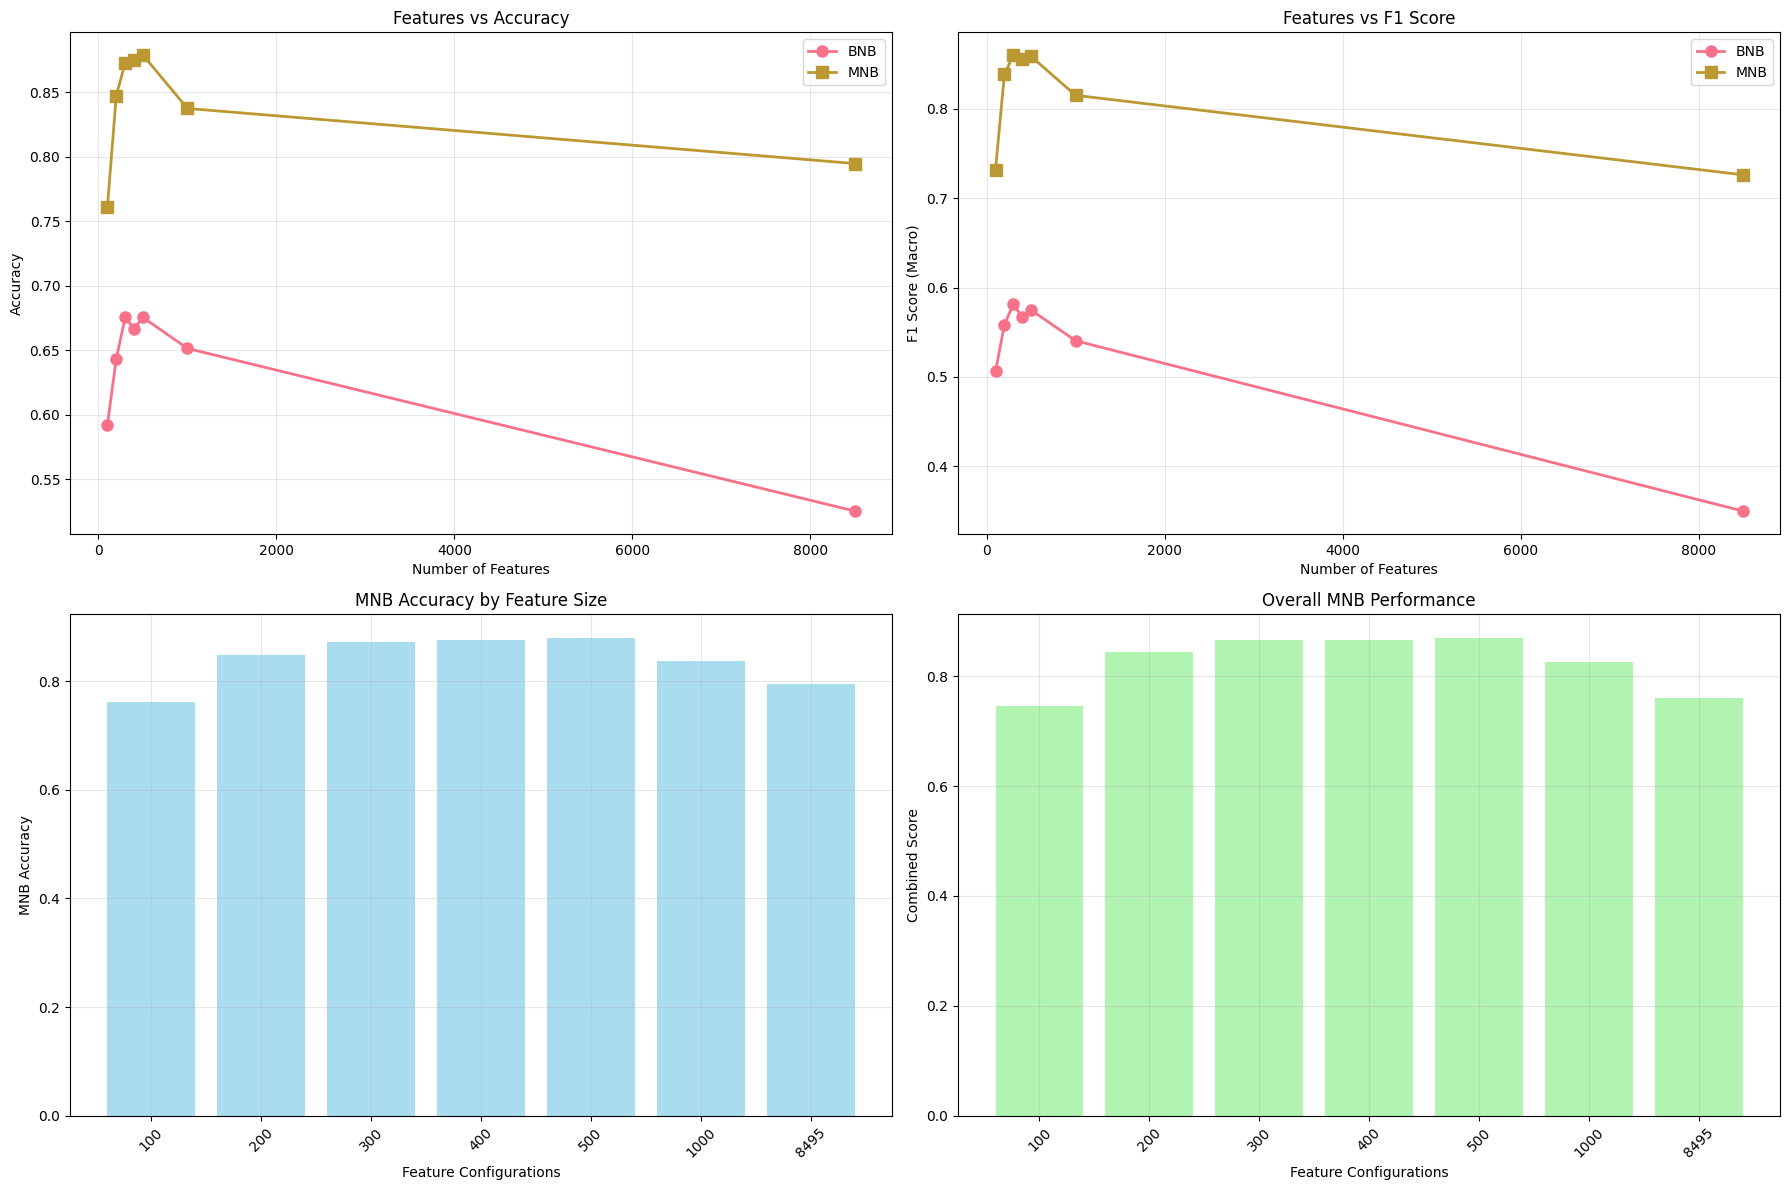


Performance Summary:
--------------------------------------------------------------------------------
max_feat   actual   BNB_Acc    BNB_F1     MNB_Acc    MNB_F1    
--------------------------------------------------------------------------------
100        100      0.592      0.506      0.761      0.732     
200        200      0.643      0.558      0.847      0.838     
300        300      0.675      0.582      0.873      0.860     
400        400      0.667      0.567      0.875      0.856     
500        500      0.675      0.575      0.879      0.859     
1000       1000     0.651      0.541      0.837      0.815     
8495       8495     0.525      0.350      0.795      0.726     

Optimal Configuration Summary:
Best Number of Features: 500
MNB Accuracy at Optimal: 0.8787
MNB F1 Score at Optimal: 0.8586

Observed Trends:
------------------------------
Accuracy increases then decreases: confirms optimal vocab size exists.
Average MNB Accuracy (0.838) is higher than BNB (0.633).
Mu

In [6]:
# Problem 4: 特征数量影响分析可视化和结论
def analyze_and_visualize_feature_impact(feature_results):
    print("Problem 4: Feature Size Impact Analysis")
    print("=" * 60)

    # Create 2x3 subplots
    fig, axes = plt.subplots(2, 2, figsize=(18, 12))

    # 1. Accuracy comparison
    axes[0, 0].plot(feature_results['actual_features'], feature_results['BNB_accuracy'], 
                    'o-', label='BNB', linewidth=2, markersize=8)
    axes[0, 0].plot(feature_results['actual_features'], feature_results['MNB_accuracy'], 
                    's-', label='MNB', linewidth=2, markersize=8)
    axes[0, 0].set_xlabel('Number of Features')
    axes[0, 0].set_ylabel('Accuracy')
    axes[0, 0].set_title('Features vs Accuracy')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # 2. F1 Score comparison
    axes[0, 1].plot(feature_results['actual_features'], feature_results['BNB_f1'], 
                    'o-', label='BNB', linewidth=2, markersize=8)
    axes[0, 1].plot(feature_results['actual_features'], feature_results['MNB_f1'], 
                    's-', label='MNB', linewidth=2, markersize=8)
    axes[0, 1].set_xlabel('Number of Features')
    axes[0, 1].set_ylabel('F1 Score (Macro)')
    axes[0, 1].set_title('Features vs F1 Score')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # 3. MNB Accuracy Bar Plot
    axes[1, 0].bar(range(len(feature_results['actual_features'])), feature_results['MNB_accuracy'], 
                   alpha=0.7, color='skyblue')
    axes[1, 0].set_xlabel('Feature Configurations')
    axes[1, 0].set_ylabel('MNB Accuracy')
    axes[1, 0].set_title('MNB Accuracy by Feature Size')
    axes[1, 0].set_xticks(range(len(feature_results['actual_features'])))
    axes[1, 0].set_xticklabels([str(f) for f in feature_results['actual_features']], rotation=45)
    axes[1, 0].grid(True, alpha=0.3)

    # 4. Combined Score (Acc + F1) / 2
    combined_score = [(acc + f1) / 2 for acc, f1 in 
                      zip(feature_results['MNB_accuracy'], feature_results['MNB_f1'])]
    axes[1, 1].bar(range(len(combined_score)), combined_score, alpha=0.7, color='lightgreen')
    axes[1, 1].set_xlabel('Feature Configurations')
    axes[1, 1].set_ylabel('Combined Score')
    axes[1, 1].set_title('Overall MNB Performance')
    axes[1, 1].set_xticks(range(len(feature_results['actual_features'])))
    axes[1, 1].set_xticklabels([str(f) for f in feature_results['actual_features']], rotation=45)
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Print summary table
    print("\nPerformance Summary:")
    print("-" * 80)
    print(f"{'max_feat':<10} {'actual':<8} {'BNB_Acc':<10} {'BNB_F1':<10} {'MNB_Acc':<10} {'MNB_F1':<10}")
    print("-" * 80)

    for i in range(len(feature_results['actual_features'])):
        max_feat = feature_results['max_features'][i]
        actual_feat = feature_results['actual_features'][i]
        bnb_acc = feature_results['BNB_accuracy'][i]
        bnb_f1 = feature_results['BNB_f1'][i]
        mnb_acc = feature_results['MNB_accuracy'][i]
        mnb_f1 = feature_results['MNB_f1'][i]

        print(f"{str(max_feat):<10} {actual_feat:<8} {bnb_acc:<10.3f} {bnb_f1:<10.3f} "
              f"{mnb_acc:<10.3f} {mnb_f1:<10.3f}")

    # Identify optimal setting
    best_idx = np.argmax(combined_score)
    optimal_features = feature_results['actual_features'][best_idx]
    optimal_accuracy = feature_results['MNB_accuracy'][best_idx]
    optimal_f1 = feature_results['MNB_f1'][best_idx]

    print("\nOptimal Configuration Summary:")
    print("=" * 50)
    print(f"Best Number of Features: {optimal_features}")
    print(f"MNB Accuracy at Optimal: {optimal_accuracy:.4f}")
    print(f"MNB F1 Score at Optimal: {optimal_f1:.4f}")

    # Additional insights
    print("\nObserved Trends:")
    print("-" * 30)

    scores = feature_results['MNB_accuracy']
    peak_idx = np.argmax(scores)

    if 0 < peak_idx < len(scores) - 1:
        print("Accuracy increases then decreases: confirms optimal vocab size exists.")

    avg_bnb = np.mean(feature_results['BNB_accuracy'])
    avg_mnb = np.mean(feature_results['MNB_accuracy'])

    print(f"Average MNB Accuracy ({avg_mnb:.3f}) is higher than BNB ({avg_bnb:.3f}).")
    print("Multinomial NB is more suitable for frequency-based vectorization.")

    return optimal_features
optimal_n = analyze_and_visualize_feature_impact(feature_results)

### Conclusion
Based on the results achieved, the optimal values for max_features in CountVectorizer is 500， which achieves the best balance between accuracy and macro F1-score.  
When the vocabulary size is too small  (100–200), valuable information is lost, resulting in poor semantic representation. In contrast, when vocabulary size increases over 500, the performance becomes poorer with noises.

## Question 5: Third Model Comparison - Logistic Regression

**Model Choice**: Logistic Regression

**Reason**: 
Logistic Regression is a widely used linear model for text classification, well performed on tasks involving high-dimensional sparse feature spaces. By modeling class probabilities through maximum likelihood estimation, it used the sigmoid function to map linear features combination to values between 0 and 1. Furthermore, because of robustness to high-dimensional data, it could adjust linear relationships between features and prevent overfitting by applying L1 or L2 regularization.

In [7]:
# Using the same preprocess steps as previous models
def preprocess_text(text):
    if not isinstance(text, str):
        return ""
    
    text = text.lower()
    text = re.sub(r'[^\w\s!?\'\-]', ' ', text) 
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def final_model_comparison(df, max_features=500):
    # Apply preprocessing
    processed_lyrics = df['lyrics'].apply(lambda x: preprocess_text(x))
    y = df['topic']

    vectorizer = CountVectorizer(max_features=max_features)
    X = vectorizer.fit_transform(processed_lyrics)

    print(f"\nLogistic Regression Hyperparameter Tuning:")
    print("-" * 40)
    C_values = [0.1, 1, 10]
    best_C = 1
    best_lr_score = 0
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    for C in C_values:
        lr_temp = LogisticRegression(C=C, random_state=42, max_iter=1000)
        lr_scores = cross_val_score(lr_temp, X, y, cv=skf, scoring='accuracy')
        avg_score = lr_scores.mean()
        print(f"C={C}: Accuracy={avg_score:.4f} (±{lr_scores.std():.4f})")
        if avg_score > best_lr_score:
            best_lr_score = avg_score
            best_C = C

    print(f"Best C value: {best_C} (Accuracy: {best_lr_score:.4f})")

    models = {
        'Bernoulli NB': BernoulliNB(),
        'Multinomial NB': MultinomialNB(),
        'Logistic Regression': LogisticRegression(C=best_C, random_state=42, max_iter=1000)
    }

    results = {}
    print(f"\nFinal Model Performance Comparison:")
    print("=" * 50)

    for name, model in models.items():
        print(f"\n{name}:")
        print("-" * 35)
        accuracy_scores = cross_val_score(model, X, y, cv=skf, scoring='accuracy')
        f1_scores = cross_val_score(model, X, y, cv=skf, scoring='f1_macro')
        precision_scores = cross_val_score(model, X, y, cv=skf, scoring='precision_macro')
        recall_scores = cross_val_score(model, X, y, cv=skf, scoring='recall_macro')

        results[name] = {
            'accuracy': accuracy_scores,
            'f1_macro': f1_scores,
            'precision_macro': precision_scores,
            'recall_macro': recall_scores,
            'C_value': best_C if 'Logistic' in name else None
        }

        print(f"Accuracy:  {accuracy_scores.mean():.4f} (±{accuracy_scores.std():.4f})")
        print(f"F1-Score:  {f1_scores.mean():.4f} (±{f1_scores.std():.4f})")
        print(f"Precision: {precision_scores.mean():.4f} (±{precision_scores.std():.4f})")
        print(f"Recall:    {recall_scores.mean():.4f} (±{recall_scores.std():.4f})")
        if 'Logistic' in name:
            print(f"Used C value: {best_C}")

    return results, X, y, vectorizer, best_C

final_results, X_final, y_final, vectorizer_final, optimal_C = final_model_comparison(df)


Logistic Regression Hyperparameter Tuning:
----------------------------------------
C=0.1: Accuracy=0.8827 (±0.0181)
C=1: Accuracy=0.8847 (±0.0182)
C=10: Accuracy=0.8700 (±0.0167)
Best C value: 1 (Accuracy: 0.8847)

Final Model Performance Comparison:

Bernoulli NB:
-----------------------------------
Accuracy:  0.6753 (±0.0144)
F1-Score:  0.5748 (±0.0111)
Precision: 0.5909 (±0.0123)
Recall:    0.5738 (±0.0106)

Multinomial NB:
-----------------------------------
Accuracy:  0.8787 (±0.0230)
F1-Score:  0.8586 (±0.0278)
Precision: 0.8689 (±0.0261)
Recall:    0.8513 (±0.0306)

Logistic Regression:
-----------------------------------
Accuracy:  0.8847 (±0.0182)
F1-Score:  0.8676 (±0.0220)
Precision: 0.8846 (±0.0259)
Recall:    0.8560 (±0.0247)
Used C value: 1


**Fine tuning**:I choosed the default set up for L2 regularization, and fine tuned the hyperparameter C(inverse of regularization strength). With several experiment of values [0.1, 1 ,10], I choosed C = 1 as the fine tuning configuration  based on the cross-validation accuracy.

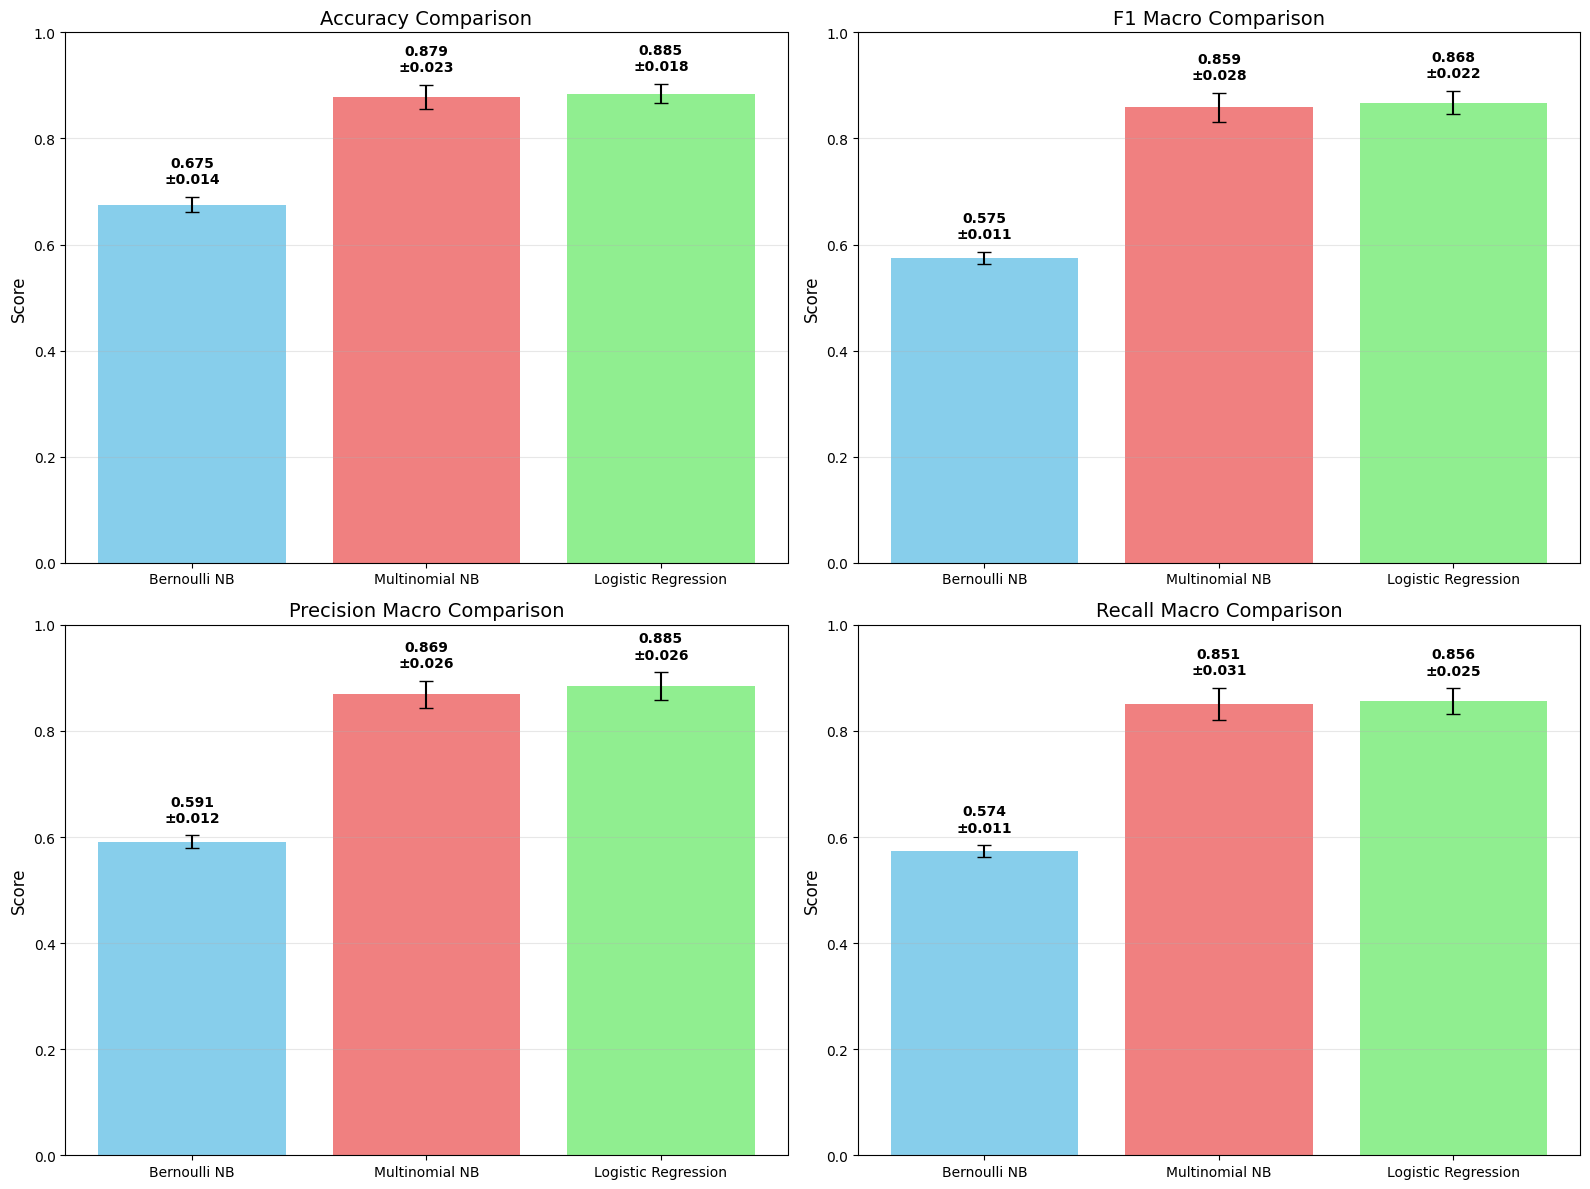

In [8]:
# Visualize final model comparison
def plot_final_results(results):

    models = list(results.keys())
    metrics = ['accuracy', 'f1_macro', 'precision_macro', 'recall_macro']
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.flatten()
    
    colors = ['skyblue', 'lightcoral', 'lightgreen']
    
    for i, metric in enumerate(metrics):
        means = [results[model][metric].mean() for model in models]
        stds = [results[model][metric].std() for model in models]
        
        bars = axes[i].bar(models, means, yerr=stds, capsize=5, color=colors)
        axes[i].set_title(f'{metric.replace("_", " ").title()} Comparison', fontsize=14)
        axes[i].set_ylabel('Score', fontsize=12)
        axes[i].set_ylim(0, 1)
        axes[i].grid(axis='y', alpha=0.3)
        
        # Add value labels
        for j, (mean, std) in enumerate(zip(means, stds)):
            axes[i].text(j, mean + std + 0.02, f'{mean:.3f}\n±{std:.3f}', 
                        ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    plt.tight_layout()
    plt.show()

plot_final_results(final_results)

Detailed Model Analysis - Confusion Matrices & Feature Analysis

Multinomial NB Detailed Analysis:
------------------------------
Test Accuracy: 0.8933

Multinomial NB Classification Report:
              precision    recall  f1-score   support

        dark       0.91      0.91      0.91        98
     emotion       0.79      0.88      0.83        17
   lifestyle       0.90      0.85      0.88        41
    personal       0.90      0.94      0.92        69
     sadness       0.89      0.85      0.87        75

    accuracy                           0.89       300
   macro avg       0.88      0.89      0.88       300
weighted avg       0.89      0.89      0.89       300


Logistic Regression Detailed Analysis:
------------------------------
Test Accuracy: 0.8667

Logistic Regression Classification Report:
              precision    recall  f1-score   support

        dark       0.87      0.89      0.88        98
     emotion       0.79      0.88      0.83        17
   lifestyle       0

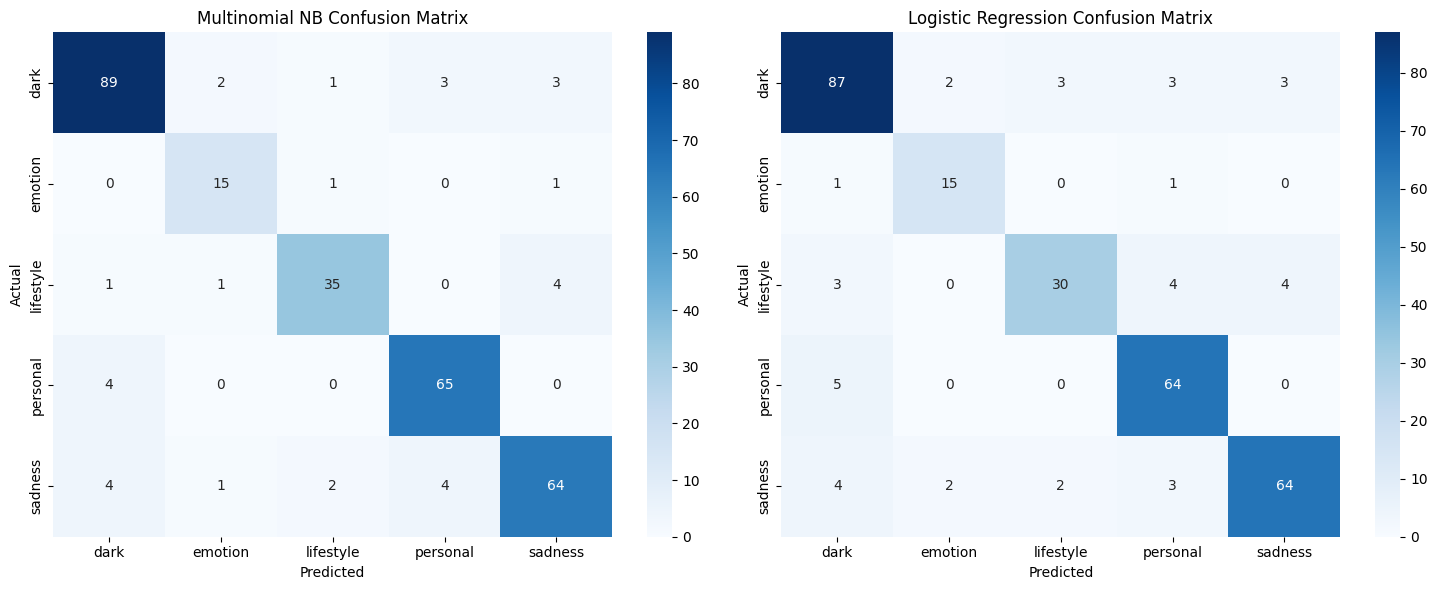

Performance Comparison:
• LR accuracy: 0.8847
• MNB accuracy: 0.8787
• BNB accuracy: 0.6753


In [9]:
# Detailed Confusion Matrix and Feature Importance Analysis
print("Detailed Model Analysis - Confusion Matrices & Feature Analysis")
print("=" * 60)

# Single train-test split for confusion matrix visualization
X_train, X_test, y_train, y_test = train_test_split(
    X_final, y_final, test_size=0.2, random_state=42, stratify=y_final
)

# Train and evaluate the best models
best_models = {
    'Multinomial NB': MultinomialNB(),
    'Logistic Regression': LogisticRegression(C=optimal_C, random_state=42, max_iter=1000)
}

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

for idx, (name, model) in enumerate(best_models.items()):
    print(f"\n{name} Detailed Analysis:")
    print("-" * 30)
    
    # Train and predict
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Test accuracy
    test_accuracy = accuracy_score(y_test, y_pred)
    print(f"Test Accuracy: {test_accuracy:.4f}")
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    # Plot confusion matrix
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=model.classes_, yticklabels=model.classes_,
                ax=axes[idx])
    axes[idx].set_title(f'{name} Confusion Matrix')
    axes[idx].set_xlabel('Predicted')
    axes[idx].set_ylabel('Actual')
    
    # Classification report
    print(f"\n{name} Classification Report:")
    print(classification_report(y_test, y_pred))

plt.tight_layout()
plt.show()

print("Performance Comparison:")
lr_acc = final_results['Logistic Regression']['accuracy'].mean()
mnb_acc = final_results['Multinomial NB']['accuracy'].mean()
bnb_acc = final_results['Bernoulli NB']['accuracy'].mean()
print(f"• LR accuracy: {lr_acc:.4f}")
print(f"• MNB accuracy: {mnb_acc:.4f}")  
print(f"• BNB accuracy: {bnb_acc:.4f}")


**Conclusion**
    From the tables, we can found that the Logestic Regression has better performence than both Naive Bayes models for this dataset, including F1-Score and accuracy score. Moreover, it could be found from confusion matrix  that Logestic Regression has the best performance on handling imbalanced data in these three models. Compared with strong conditional independence assumption of MNB,Logistic Regression can learn more nuanced combinations of feature weights.  
    Therefore, the "best" method and settings are Logestic Regression with default L2 regularization and C = 1, with Stratified 5-Fold Cross-Validation, 'preserve_emotional expressioon preprocessing', 'sklearn tokenizer' and applying lowercase.

# Part 2: Recommendation Methods - Question 1

## Information Retrieval-based Recommendation System

This notebook implements an information retrieval algorithm for matching user profiles to songs using TF-IDF vectors. The system uses the optimal classifier from Part 1 (Logistic Regression with C=1) to predict song topics, then recommends songs based on TF-IDF similarity between user profiles and new songs.


### Key Components:
1. **Topic Classification**: Use Part 1's best model (LR, C=1, 500 features, gentle preprocessing)
2. **Temporal Data Split**: Weeks 1-3 (songs 1-750) as training, Week 4 (songs 751-1000) as test
3. **User Profile Creation**: TF-IDF vectors based on liked songs in predicted topics
4. **Recommendation**: Match new songs to user profiles via TF-IDF similarity

In [ ]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter, defaultdict

# Machine learning imports
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import euclidean_distances

# Set random seed for reproducibility
np.random.seed(42)

In [ ]:
# Load and prepare data using Part 1's optimal preprocessing
def select_preprocess(text):
    if not isinstance(text, str):
        return ""
    
    # Convert to lowercase
    text = text.lower()
    
    # Preserve emotional symbols and contractions 
    text = re.sub(r'[^\w\s!?\'\-]', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    
    return text.strip()

# Load dataset
df = pd.read_csv('dataset.tsv', sep='\t')
print(f"Dataset shape: {df.shape}")

# Apply optimal preprocessing from Part 1
df['lyrics_clean'] = df['lyrics'].apply(select_preprocess)
print("Applied preprocessing, the optimal method from Part 1)")

# Create temporal split as specified in the question
# Weeks 1-3: songs 1-750 (training)
# Week 4: songs 751-1000 (test)
train_data = df.iloc[:750].copy()  # Weeks 1-3
test_data = df.iloc[750:1000].copy()  # Week 4
remaining_data = df.iloc[1000:].copy()  # Week 5-6 (not used in this question)

print(f"\nTemporal data split:")
print(f"Training data (Weeks 1-3): {len(train_data)} songs")
print(f"Test data (Week 4): {len(test_data)} songs")
print(f"Remaining data (Weeks 5-6): {len(remaining_data)} songs")

print(f"\nTopic distribution in training data:")
print(train_data['topic'].value_counts())

Dataset shape: (1500, 6)
Applied preprocessing, the optimal method from Part 1)

Temporal data split:
Training data (Weeks 1-3): 750 songs
Test data (Week 4): 250 songs
Remaining data (Weeks 5-6): 500 songs

Topic distribution in training data:
topic
dark         246
personal     188
sadness      182
lifestyle     92
emotion       42
Name: count, dtype: int64


In [ ]:
# Train the optimal classifier from Part 1 on training data
print("Model: Logistic Regression (C=1), Features: 500, Preprocessing: gentle")

# Use optimal settings from Part 1
vectorizer_classifier = CountVectorizer(max_features=500, stop_words='english')
X_train_class = vectorizer_classifier.fit_transform(train_data['lyrics_clean'])
y_train_class = train_data['topic']

# Train optimal Logistic Regression model (C=1 from Part 1)
classifier = LogisticRegression(C=1, random_state=42, max_iter=1000)
classifier.fit(X_train_class, y_train_class)

# Predict topics for all songs (needed for user profile creation)
X_all_class = vectorizer_classifier.transform(df['lyrics_clean'])
df['predicted_topic'] = classifier.predict(X_all_class)

# Also predict for train/test splits
train_data['predicted_topic'] = classifier.predict(X_train_class)
X_test_class = vectorizer_classifier.transform(test_data['lyrics_clean'])
test_data['predicted_topic'] = classifier.predict(X_test_class)

# Evaluate classifier accuracy on training data
train_accuracy = (train_data['topic'] == train_data['predicted_topic']).mean()
print(f"\nClassifier performance on training data:")
print(f"Accuracy: {train_accuracy:.3f}")

print(f"\nPredicted topic distribution in training data:")
print(train_data['predicted_topic'].value_counts())

Model: Logistic Regression (C=1), Features: 500, Preprocessing: gentle

Classifier performance on training data:
Accuracy: 1.000

Predicted topic distribution in training data:
predicted_topic
dark         246
personal     188
sadness      182
lifestyle     92
emotion       42
Name: count, dtype: int64


It could found that there is over-fitting problem for using the best model from part 1. Since we set the max feature as 500, while the input size is only 750. 

In [ ]:
# Load user preferences from TSV files
def load_user_preferences(filename):
    """
    Load user preferences from TSV file
    Format: topic<tab>keyword1, keyword2, keyword3, ...
    """
    preferences = {}
    try:
        with open(filename, 'r', encoding='utf-8') as file:
            for line in file:
                line = line.strip()
                if line and not line.startswith('#'):  # Skip empty lines and comments
                    parts = line.split('\t')
                    if len(parts) >= 2:
                        topic = parts[0].strip()
                        keywords = [kw.strip().lower() for kw in parts[1].split(',')]
                        preferences[topic] = keywords
        return preferences
    except FileNotFoundError:
        print(f"File {filename} not found")
        return {}

# Load User 1 and User 2 preferences
print("Loading user preferences...")
user1_prefs = load_user_preferences('user1.tsv')
user1_prefs.pop('topic')
user2_prefs = load_user_preferences('user2.tsv')
user2_prefs.pop('topic')

print("\nUser 1 preferences:")
for topic, keywords in user1_prefs.items():
    print(f"{topic}: {keywords}")

print("\nUser 2 preferences:")
for topic, keywords in user2_prefs.items():
    print(f"{topic}: {keywords}")

# Create User 3 preferences 
user3_prefs = {
    'emotion': ['love', 'heart', 'feel', 'soul',],
    'dark': ['shadow', 'black', 'pain', 'lost', 'alone'],
    'lifestyle': ['party', 'friends', 'good', 'life', 'free'],
    'personal': ['myself', 'identity', 'journey', 'soul'],
    'sadness': ['cry', 'tears', 'lonely', 'empty', 'miss']
}

print("\nUser 3 preferences (custom - diverse interests):")
for topic, keywords in user3_prefs.items():
    print(f"{topic}: {keywords}")

Loading user preferences...

User 1 preferences:
dark: ['fire', 'enemy', 'pain', 'storm', 'fight']
sadness: ['cry', 'alone', 'heartbroken', 'tears', 'regret']
personal: ['dream', 'truth', 'life', 'growth', 'identity']
lifestyle: ['party', 'city', 'night', 'light', 'rhythm']
emotion: ['love', 'memory', 'hug', 'kiss', 'feel']

User 2 preferences:
sadness: ['lost', 'sorrow', 'goodbye', 'tears', 'silence']
emotion: ['romance', 'touch', 'feeling', 'kiss', 'memory']

User 3 preferences (custom - diverse interests):
emotion: ['love', 'heart', 'feel', 'soul']
dark: ['shadow', 'black', 'pain', 'lost', 'alone']
lifestyle: ['party', 'friends', 'good', 'life', 'free']
personal: ['myself', 'identity', 'journey', 'soul']
sadness: ['cry', 'tears', 'lonely', 'empty', 'miss']


In [ ]:
# Create TF-IDF vectorizers for each predicted topic using training data
print("Following the algorithm: construct 5 TF-IDF matrices, one for each predicted topic")
# Create topic-specific TF-IDF vectorizers
topic_vectorizers = {}
topic_tfidf_matrices = {}

# Get unique predicted topics from training data
predicted_topics = train_data['predicted_topic'].unique()

for topic in predicted_topics:
    # Get songs predicted to be in this topic from training data
    topic_songs = train_data[train_data['predicted_topic'] == topic]['lyrics_clean']
    
    if len(topic_songs) > 0:
        # Create TF-IDF vectorizer for this topic
        # Using standard settings for TF-IDF
        vectorizer = TfidfVectorizer(
            max_features=500,  # Allow more features for TF-IDF than classification
            stop_words='english',
            min_df=2,  # Ignore terms that appear in fewer than 2 documents
            max_df=0.8  # Ignore terms that appear in more than 80% of documents
        )
        
        # Fit the vectorizer on songs in this topic
        tfidf_matrix = vectorizer.fit_transform(topic_songs)
        
        topic_vectorizers[topic] = vectorizer
        topic_tfidf_matrices[topic] = tfidf_matrix
        
        print(f"Topic '{topic}': {len(topic_songs)} songs, {tfidf_matrix.shape[1]} TF-IDF features")
    else:
        print(f"Warning: No songs found for predicted topic '{topic}'")

print(f"\nSuccessfully created TF-IDF vectorizers for {len(topic_vectorizers)} topics")

Following the algorithm: construct 5 TF-IDF matrices, one for each predicted topic
Topic 'dark': 246 songs, 500 TF-IDF features
Topic 'lifestyle': 92 songs, 434 TF-IDF features
Topic 'sadness': 182 songs, 500 TF-IDF features
Topic 'emotion': 42 songs, 218 TF-IDF features
Topic 'personal': 188 songs, 500 TF-IDF features

Successfully created TF-IDF vectorizers for 5 topics


In [ ]:
# Function to check if a song matches user preferences
def song_matches_user_preferences(lyrics, user_keywords):
    lyrics_words = set(lyrics.lower().split())
    keyword_set = set([kw.lower() for kw in user_keywords])
    return len(lyrics_words.intersection(keyword_set)) > 0

# Create user profiles based on liked songs from training data
def create_user_profile(user_prefs, train_data, topic_vectorizers):

    user_profile = {}
    user_liked_songs = {}
    
    print(f"Creating user profile from training data (Weeks 1-3)...")
    
    for topic in user_prefs.keys():
        if topic not in topic_vectorizers:
            print(f"Warning: No TF-IDF vectorizer found for topic '{topic}'")
            continue
            
        # Get songs predicted to be in this topic from training data
        topic_songs = train_data[train_data['predicted_topic'] == topic]
        
        # Find songs that match user preferences (simulation of user "likes")
        liked_songs = []
        for idx, row in topic_songs.iterrows():
            if song_matches_user_preferences(row['lyrics_clean'], user_prefs[topic]):
                liked_songs.append(row['lyrics_clean'])
        
        user_liked_songs[topic] = len(liked_songs)
        
        if liked_songs:
            # Combine all liked songs into one larger document
            combined_document = ' '.join(liked_songs)
            
            # Transform using the topic's TF-IDF vectorizer
            vectorizer = topic_vectorizers[topic]
            tfidf_vector = vectorizer.transform([combined_document])
            
            # Get feature names and TF-IDF scores
            feature_names = vectorizer.get_feature_names_out()
            tfidf_scores = tfidf_vector.toarray()[0]
            
            # Create word-score pairs and sort by TF-IDF score
            word_scores = list(zip(feature_names, tfidf_scores))
            word_scores = [(word, score) for word, score in word_scores if score > 0]
            word_scores.sort(key=lambda x: x[1], reverse=True)
            
            user_profile[topic] = {
                'tfidf_vector': tfidf_vector,
                'word_scores': word_scores,
                'liked_songs_count': len(liked_songs),
                'combined_document_length': len(combined_document.split())
            }
            
            print(f"Topic '{topic}': {len(liked_songs)} liked songs -> {len(word_scores)} TF-IDF features")
        else:
            print(f"Warning: No liked songs found for user in topic '{topic}'")
    
    return user_profile, user_liked_songs

# Create profiles for all three users
print("\n" + "="*60)
print("USER PROFILES FROM TRAINING DATA (Weeks 1-3)")
print("="*60)

print("\nUser 1 Profile Creation:")
user1_profile, user1_liked = create_user_profile(user1_prefs, train_data, topic_vectorizers)

print("\nUser 2 Profile Creation:")
user2_profile, user2_liked = create_user_profile(user2_prefs, train_data, topic_vectorizers)

print("\nUser 3 Profile Creation:")
user3_profile, user3_liked = create_user_profile(user3_prefs, train_data, topic_vectorizers)

print(f"\n" + "="*60)
print("USER PROFILE CREATION SUMMARY")
print("="*60)
print(f"User 1 liked songs by topic: {user1_liked}")
print(f"User 2 liked songs by topic: {user2_liked}")
print(f"User 3 liked songs by topic: {user3_liked}")


USER PROFILES FROM TRAINING DATA (Weeks 1-3)

User 1 Profile Creation:
Creating user profile from training data (Weeks 1-3)...
Topic 'dark': 66 liked songs -> 447 TF-IDF features
Topic 'sadness': 11 liked songs -> 173 TF-IDF features
Topic 'personal': 114 liked songs -> 489 TF-IDF features
Topic 'lifestyle': 35 liked songs -> 368 TF-IDF features
Topic 'emotion': 25 liked songs -> 206 TF-IDF features

User 2 Profile Creation:
Creating user profile from training data (Weeks 1-3)...
Topic 'sadness': 18 liked songs -> 243 TF-IDF features
Topic 'emotion': 12 liked songs -> 147 TF-IDF features

User 3 Profile Creation:
Creating user profile from training data (Weeks 1-3)...
Topic 'emotion': 30 liked songs -> 215 TF-IDF features
Topic 'dark': 50 liked songs -> 432 TF-IDF features
Topic 'lifestyle': 36 liked songs -> 355 TF-IDF features
Topic 'personal': 26 liked songs -> 334 TF-IDF features
Topic 'sadness': 31 liked songs -> 311 TF-IDF features

USER PROFILE CREATION SUMMARY
User 1 liked son

In [ ]:
# Display top 20 words in user profiles for each topic
def display_user_profile_words(user_profile, user_name):

    print(f"\n{user_name} Profile - Top 20 TF-IDF Words by Topic:")
    print("=" * 70)
    
    for topic, profile_data in user_profile.items():
        print(f"\nTopic: {topic.upper()}")
        print(f"Liked songs: {profile_data['liked_songs_count']}")
        print(f"Combined document length: {profile_data['combined_document_length']} words")
        print("-" * 50)
        
        word_scores = profile_data['word_scores'][:20]
        for i, (word, score) in enumerate(word_scores, 1):
            print(f"{i:2d}. {word:15} : {score:.4f}")
            
        # Comment on reasonableness
        if word_scores:
            top_5_words = [word for word, _ in word_scores[:5]]
            print(f"\nTop 5 words: {top_5_words}")
            print(f"Comment: These words {'appear' if len(top_5_words) > 0 else 'do not appear'} to be "
                  f"semantically related to the '{topic}' topic and user interests.")
# Create the missing dictionaries for the final evaluation
user_profiles_dict = {
    'User 1': user1_profile,
    'User 2': user2_profile,
    'User 3': user3_profile
}

users_data = {
    'User 1': user1_prefs,
    'User 2': user2_prefs,
    'User 3': user3_prefs
}
# Display profiles for all users
display_user_profile_words(user1_profile, "USER 1")
display_user_profile_words(user2_profile, "USER 2")
display_user_profile_words(user3_profile, "USER 3")


USER 1 Profile - Top 20 TF-IDF Words by Topic:

Topic: DARK
Liked songs: 66
Combined document length: 5867 words
--------------------------------------------------
 1. fight           : 0.3902
 2. blood           : 0.1913
 3. like            : 0.1861
 4. know            : 0.1832
 5. stand           : 0.1689
 6. tell            : 0.1555
 7. grind           : 0.1537
 8. black           : 0.1476
 9. gonna           : 0.1463
10. kill            : 0.1414
11. yeah            : 0.1273
12. head            : 0.1233
13. follow          : 0.1187
14. people          : 0.1154
15. hand            : 0.1108
16. come            : 0.1055
17. shoot           : 0.0996
18. pain            : 0.0987
19. time            : 0.0947
20. slow            : 0.0942

Top 5 words: ['fight', 'blood', 'like', 'know', 'stand']
Comment: These words appear to be semantically related to the 'dark' topic and user interests.

Topic: SADNESS
Liked songs: 11
Combined document length: 735 words
----------------------------------

In [ ]:
# Similarity-Based Recommendation Quality Evaluation
def evaluate_recommendation_quality_by_similarity(user_profiles_dict, users_data, test_data, topic_vectorizers):
    """
    Comprehensive evaluation of recommendation quality based on similarity scores
    """
    print("RECOMMENDATION QUALITY EVALUATION BY SIMILARITY")
    print("-" * 60)
    
    for user_name in user_profiles_dict.keys():
        user_profile = user_profiles_dict[user_name]
        user_prefs = users_data[user_name]
        
        print(f"{user_name} Recommendation Quality Assessment:")
        print("-" * 45)
        
        # Calculate similarities for all test songs
        song_similarities = []
        
        for idx, row in test_data.iterrows():
            song_lyrics = row['lyrics_clean']
            predicted_topic = row['predicted_topic']
            
            if predicted_topic in user_profile and predicted_topic in topic_vectorizers:
                vectorizer = topic_vectorizers[predicted_topic]
                song_vector = vectorizer.transform([song_lyrics])
                user_vector = user_profile[predicted_topic]['tfidf_vector']
                similarity = cosine_similarity(user_vector, song_vector)[0][0]
                
                # Check if song matches user interests
                is_relevant = False
                if predicted_topic in user_prefs:
                    is_relevant = song_matches_user_preferences(song_lyrics, user_prefs[predicted_topic])
                
                song_similarities.append({
                    'song_idx': idx,
                    'similarity': similarity,
                    'predicted_topic': predicted_topic,
                    'is_relevant': is_relevant,
                    'artist': row['artist_name'],
                    'track': row['track_name']
                })
        
        # Sort by similarity (highest first)
        song_similarities.sort(key=lambda x: x['similarity'], reverse=True)
        
        # Analyze top recommendations
        top_10 = song_similarities[:10]
        
        print(f"\nTop 10 Recommendations Analysis:")
        top_10_relevant = sum(1 for song in top_10 if song['is_relevant'])
        top_10_avg_sim = np.mean([song['similarity'] for song in top_10])
        top_10_min_sim = min([song['similarity'] for song in top_10])
        
        print(f"  Relevant songs in top 10: {top_10_relevant}/10 ({top_10_relevant/10:.1%})")
        print(f"  Average similarity: {top_10_avg_sim:.4f}")
        print(f"  Minimum similarity: {top_10_min_sim:.4f}")
    
        
        # Show top 5 recommendations with details
        print(f"\nTop 5 Recommendations with Similarity Scores:")
        for i, song in enumerate(top_10[:5], 1):
            relevance = "✓ RELEVANT" if song['is_relevant'] else "○ Not relevant"
            print(f"  {i}. Similarity: {song['similarity']:.4f} | {relevance}")
            print(f"     Artist: {song['artist']} - Track: {song['track']}")
            print(f"     Topic: {song['predicted_topic']}")

# Run similarity-based recommendation quality evaluation
evaluate_recommendation_quality_by_similarity(user_profiles_dict, users_data, test_data, topic_vectorizers)

RECOMMENDATION QUALITY EVALUATION BY SIMILARITY
------------------------------------------------------------
User 1 Recommendation Quality Assessment:
---------------------------------------------

Top 10 Recommendations Analysis:
  Relevant songs in top 10: 10/10 (100.0%)
  Average similarity: 0.4914
  Minimum similarity: 0.3849

Top 5 Recommendations with Similarity Scores:
  1. Similarity: 0.6718 | ✓ RELEVANT
     Artist: timeflies - Track: once in a while
     Topic: emotion
  2. Similarity: 0.6385 | ✓ RELEVANT
     Artist: justin moore - Track: got it good
     Topic: emotion
  3. Similarity: 0.6129 | ✓ RELEVANT
     Artist: taylor swift - Track: i did something bad
     Topic: emotion
  4. Similarity: 0.5666 | ✓ RELEVANT
     Artist: dirty heads - Track: horsefly
     Topic: emotion
  5. Similarity: 0.4403 | ✓ RELEVANT
     Artist: the band steele - Track: sit awhile
     Topic: personal
User 2 Recommendation Quality Assessment:
---------------------------------------------

Top 

# Part 2: Recommendation Methods - Question 2

## Choosing Metrics
### EVALUATION METRICS:
    1. Precision@N:Percentage of recommended N songs that match user interests(quality)  
    2. Recall@N:Percentage of user's interested songs that were recommended(coverage)  
    3. F1@N:The mean number of precision and recall, which is useful when neither should dominate   
### N VALUE SELECTION:
**N=10**  

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter, defaultdict
import warnings
warnings.filterwarnings('ignore')

# Machine learning imports
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sklearn.model_selection import cross_val_score, StratifiedKFold

# Set random seed for reproducibility
np.random.seed(42)

In [ ]:
# class of music recommendation evaluator
class MusicRecommendationEvaluator:
    # initialize the class
    def __init__(self):
        self.df = None
        self.train_data = None
        self.test_data = None
        self.classifier = None
        self.vectorizer_classifier = None
        self.topic_vectorizers = {}
        self.users_data = {}
    
    # load and preprocess data
    def load_and_preprocess_data(self):
        print("="*80)
        print("Music Recommendation System Evaluation - Question 2")
        print("="*80)
        
        # Load dataset
        self.df = pd.read_csv('dataset.tsv', sep='\t')
        print(f"Dataset shape: {self.df.shape}")
        
        # Preprocess lyrics
        self.df['lyrics_clean'] = self.df['lyrics'].apply(self._clean_lyrics)
        
        # Temporal split: first 3 weeks for training, 4th week for testing
        print("\nData splitting strategy:")
        print("- Training data: Week 1-3 (songs 1-750)")
        print("- Test data: Week 4 (songs 751-1000)")
        print("- Assumption: 250 songs per week, arranged chronologically")
        
        self.train_data = self.df.iloc[:750].copy()
        self.test_data = self.df.iloc[750:1000].copy()
        
        print(f"Training data: {len(self.train_data)} songs")
        print(f"Test data: {len(self.test_data)} songs")

    # clean the lyrics using part 1 settings
    def _clean_lyrics(self, text):
        if not isinstance(text, str):
            return ""
        
        # Convert to lowercase
        text = text.lower()
        
        # Preserve emotional symbols and contractions 
        text = re.sub(r'[^\w\s!?\'\-]', ' ', text)
        text = re.sub(r'\s+', ' ', text)
        
        return text.strip()
    
    # train the topic classifier
    def train_classifier(self):
        print("\n" + "="*80)
        print("Training Topic Classifier")
        print("="*80)
        
        # Use conservative settings to reduce overfitting
        self.vectorizer_classifier = CountVectorizer(
            max_features=300,
            stop_words='english',
            min_df=2,
            max_df=0.8
        )
        X_train = self.vectorizer_classifier.fit_transform(self.train_data['lyrics_clean'])
        y_train = self.train_data['topic']
        
        # Cross-validation to select best model
        models = {
            'LogisticRegression': LogisticRegression(C=1, random_state=42, max_iter=1000),
            'MultinomialNB': MultinomialNB()
        }
        
        best_model = None
        best_score = 0
        
        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        
        for name, model in models.items():
            scores = cross_val_score(model, X_train, y_train, cv=skf, scoring='accuracy')
            mean_score = scores.mean()
            print(f"{name}: {mean_score:.3f} (±{scores.std():.3f})")
            
            if mean_score > best_score:
                best_score = mean_score
                best_model = model
        
        # Train best model
        self.classifier = best_model
        self.classifier.fit(X_train, y_train)
        
        # Predict topics (avoid data leakage)
        self.train_data['predicted_topic'] = self.classifier.predict(X_train)
        X_test = self.vectorizer_classifier.transform(self.test_data['lyrics_clean'])
        self.test_data['predicted_topic'] = self.classifier.predict(X_test)
        
        # Check overfitting
        train_acc = (self.train_data['topic'] == self.train_data['predicted_topic']).mean()
        test_acc = (self.test_data['topic'] == self.test_data['predicted_topic']).mean()
        print(f"\nClassifier Performance:")
        print(f"Training accuracy: {train_acc:.3f}")
        print(f"Test accuracy: {test_acc:.3f}")

    # create the topic vectorizers
    def create_topic_vectorizers(self):
        print("\n" + "="*80)
        print("Creating Topic-Specific TF-IDF Vectorizers")
        print("="*80)
        
        for topic in self.train_data['predicted_topic'].unique():
            topic_songs = self.train_data[self.train_data['predicted_topic'] == topic]['lyrics_clean']
            
            if len(topic_songs) > 0:
                vectorizer = TfidfVectorizer(
                    max_features=1000,
                    stop_words='english',
                    min_df=2,
                    max_df=0.8,
                    sublinear_tf=True
                )
                vectorizer.fit(topic_songs)
                self.topic_vectorizers[topic] = vectorizer
                print(f"Topic '{topic}': {len(topic_songs)} songs")
    
    # load the user preferences
    def load_user_preferences(self):
        print("\n" + "="*80)
        print("Loading User Preferences")
        print("="*80)
        
        def load_user_file(filename):
            preferences = {}
            try:
                with open(filename, 'r', encoding='utf-8') as file:
                    for line in file:
                        line = line.strip()
                        if line and not line.startswith('#'):
                            parts = line.split('\t')
                            if len(parts) >= 2:
                                topic = parts[0].strip()
                                keywords = [kw.strip().lower() for kw in parts[1].split(',')]
                                preferences[topic] = keywords
                return preferences
            except FileNotFoundError:
                print(f"File {filename} not found")
                return {}
        
        # Load User 1 and User 2
        user1_prefs = load_user_file('user1.tsv')
        user2_prefs = load_user_file('user2.tsv')
        
        # Create User 3 (diversified interests)
        user3_prefs = {
            'emotion': ['love', 'heart', 'feel', 'soul', 'passion', 'dream'],
            'dark': ['shadow', 'night', 'fear', 'death', 'black', 'pain'],
            'lifestyle': ['party', 'friends', 'good', 'life', 'fun', 'enjoy'],
            'personal': ['myself', 'identity', 'journey', 'growth', 'change'],
            'sadness': ['cry', 'tears', 'lonely', 'broken', 'hurt', 'sorrow']
        }
        
        # store the user preferences
        self.users_data = {
            'User 1': user1_prefs,
            'User 2': user2_prefs,
            'User 3': user3_prefs
        }
        
        # print the user preferences
        for user_name, prefs in self.users_data.items():
            print(f"\n{user_name} preferences:")
            for topic, keywords in prefs.items():
                if topic != 'topic':  # Skip header row
                    print(f"  {topic}: {keywords}")
                

In [ ]:
# Step 0: Initialize the class
evaluator = MusicRecommendationEvaluator() 

# Step 1: Load and preprocess data
evaluator.load_and_preprocess_data()

# Step 2: Train classifier
evaluator.train_classifier()

# Step 3: Create topic vectorizers
evaluator.create_topic_vectorizers()

# Step 4: Load user preferences
evaluator.load_user_preferences()

Music Recommendation System Evaluation - Question 2
Dataset shape: (1500, 6)

Data splitting strategy:
- Training data: Week 1-3 (songs 1-750)
- Test data: Week 4 (songs 751-1000)
- Assumption: 250 songs per week, arranged chronologically
Training data: 750 songs
Test data: 250 songs

Training Topic Classifier
LogisticRegression: 0.821 (±0.022)
MultinomialNB: 0.839 (±0.028)

Classifier Performance:
Training accuracy: 0.937
Test accuracy: 0.804

Creating Topic-Specific TF-IDF Vectorizers
Topic 'dark': 248 songs
Topic 'lifestyle': 94 songs
Topic 'sadness': 188 songs
Topic 'emotion': 41 songs
Topic 'personal': 179 songs

Loading User Preferences

User 1 preferences:
  dark: ['fire', 'enemy', 'pain', 'storm', 'fight']
  sadness: ['cry', 'alone', 'heartbroken', 'tears', 'regret']
  personal: ['dream', 'truth', 'life', 'growth', 'identity']
  lifestyle: ['party', 'city', 'night', 'light', 'rhythm']
  emotion: ['love', 'memory', 'hug', 'kiss', 'feel']

User 2 preferences:
  sadness: ['lost', 

In [ ]:
# function to check if the song matches the user preferences(used in create_user_profile)
def song_matches_preferences(lyrics, keywords):
    lyrics_words = set(lyrics.lower().split())
    keyword_set = set(keywords)
    return len(lyrics_words.intersection(keyword_set)) > 0

# function to create the user profile
def create_user_profile(user_prefs, train_data, topic_vectorizers, M=None):
    user_profile = {}
    
    for topic, keywords in user_prefs.items():
        if topic == 'topic':  # Skip header row
            continue
            
        if topic not in topic_vectorizers:
            continue
            
        # Get songs under this topic
        topic_songs = train_data[train_data['predicted_topic'] == topic]
        
        # Find songs user likes
        liked_songs = []
        for idx, row in topic_songs.iterrows():
            if song_matches_preferences(row['lyrics_clean'], keywords):
                liked_songs.append(row['lyrics_clean'])
        
        if liked_songs:
            # Combine all liked songs into one document
            combined_document = ' '.join(liked_songs)
            
            # Use the topic's vectorizer
            vectorizer = topic_vectorizers[topic]
            tfidf_vector = vectorizer.transform([combined_document])
            
            # Get vocabulary and scores
            feature_names = vectorizer.get_feature_names_out()
            tfidf_scores = tfidf_vector.toarray()[0]
            
            # Create word-score pairs and sort
            word_scores = list(zip(feature_names, tfidf_scores))
            word_scores = [(word, score) for word, score in word_scores if score > 0]
            word_scores.sort(key=lambda x: x[1], reverse=True)
            
            # Keep top M words
            if M is not None:
                word_scores = word_scores[:M]
                
                # Key fix: rebuild vector containing only top M words
                if len(word_scores) > 0:
                    # Create new sparse vector containing only top M words
                    top_words = [word for word, _ in word_scores]
                    new_tfidf_vector = np.zeros_like(tfidf_vector.toarray())
                    
                    for word, score in word_scores:
                        word_idx = list(feature_names).index(word)
                        new_tfidf_vector[0][word_idx] = score
                    
                    # Convert back to sparse matrix format
                    from scipy.sparse import csr_matrix
                    tfidf_vector = csr_matrix(new_tfidf_vector)
            
            user_profile[topic] = {
                'vector': tfidf_vector,
                'word_scores': word_scores,
                'liked_songs_count': len(liked_songs),
                'keywords': keywords
            }
    
    return user_profile

In [ ]:
# class of music recommender
class MusicRecommender:

    def __init__(self, topic_vectorizers, similarity_method='cosine'):
        self.topic_vectorizers = topic_vectorizers
        self.similarity_method = similarity_method
    
    # function to calculate the similarity between the user profile and the song
    def calculate_similarity(self, user_vector, song_vector):
        if self.similarity_method == 'cosine':
            return cosine_similarity(user_vector, song_vector)[0][0]
        elif self.similarity_method == 'euclidean':
            distance = euclidean_distances(user_vector, song_vector)[0][0]
            return 1 / (1 + distance)
        elif self.similarity_method == 'dot_product':
            return np.dot(user_vector.toarray()[0], song_vector.toarray()[0])
        else:
            raise ValueError(f"Unknown similarity method: {self.similarity_method}")
    
    # function to recommend the songs
    def recommend_songs(self, user_profile, test_data, N=10, per_topic=False):
        
        all_recommendations = []
        
        for topic, profile_data in user_profile.items():
            topic_recommendations = []
            
            # Get test songs for this topic
            topic_test_songs = test_data[test_data['predicted_topic'] == topic]
            
            for idx, row in topic_test_songs.iterrows():
                song_lyrics = row['lyrics_clean']
                
                # Convert song to TF-IDF vector
                vectorizer = self.topic_vectorizers[topic]
                song_vector = vectorizer.transform([song_lyrics])
                
                # Calculate similarity
                user_vector = profile_data['vector']
                similarity = self.calculate_similarity(user_vector, song_vector)
                
                topic_recommendations.append({
                    'similarity': similarity,
                    'artist': row['artist_name'],
                    'track': row['track_name'],
                    'lyrics': row['lyrics_clean'],
                    'predicted_topic': topic,
                    'true_topic': row['topic'],
                    'user_keywords': profile_data['keywords']
                })
            
            # Sort by similarity
            topic_recommendations.sort(key=lambda x: x['similarity'], reverse=True)
            
            if per_topic:
                # Recommend N songs per topic
                all_recommendations.extend(topic_recommendations[:N])
            else:
                # Merge all topics then select
                all_recommendations.extend(topic_recommendations)
        
        if not per_topic:
            # Sort by similarity and select top N
            all_recommendations.sort(key=lambda x: x['similarity'], reverse=True)
            all_recommendations = all_recommendations[:N]
        
        return all_recommendations

In [ ]:
# function to evaluate the recommendations
def evaluate_recommendations(recommendations, user_profile, test_data, N=10, topic_vectorizers=None, similarity_threshold=0.15):
    # Calculate number of relevant recommendations
    relevant_recommended = 0
    for rec in recommendations[:N]:
        song_lyrics = rec['lyrics']
        true_topic = rec['true_topic']  # Use true topic for evaluation
        
        if true_topic in user_profile and true_topic in topic_vectorizers:
            # Get user vector for this topic
            user_vector = user_profile[true_topic]['vector']
            
            # Convert song to TF-IDF vector
            vectorizer = topic_vectorizers[true_topic]
            song_vector = vectorizer.transform([song_lyrics])
            
            # Calculate cosine similarity
            similarity = cosine_similarity(user_vector, song_vector)[0][0]
            
            # Use similarity threshold to judge relevance
            if similarity >= similarity_threshold:
                relevant_recommended += 1
    
    # Calculate total relevant songs in test set
    total_relevant = 0
    for idx, row in test_data.iterrows():
        true_topic = row['topic']
        if true_topic in user_profile and true_topic in topic_vectorizers:
            # Get user vector for this topic
            user_vector = user_profile[true_topic]['vector']
            
            # Convert song to TF-IDF vector
            vectorizer = topic_vectorizers[true_topic]
            song_vector = vectorizer.transform([row['lyrics_clean']])
            
            # Calculate cosine similarity
            similarity = cosine_similarity(user_vector, song_vector)[0][0]
            
            # Use similarity threshold to judge relevance
            if similarity >= similarity_threshold:
                total_relevant += 1
    
    # Calculate metrics
    precision = relevant_recommended / N if N > 0 else 0
    recall = relevant_recommended / total_relevant if total_relevant > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    return {
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'relevant_recommended': relevant_recommended,
        'total_relevant': total_relevant,
        'total_recommended': N,
        'similarity_threshold': similarity_threshold
    }

# function to analyze the M values
def analyze_M_values(evaluator, users_data, N = 10):
    print("\n" + "="*80)
    print("M Value Analysis: Impact of User Profile Vocabulary Size")
    print("="*80)
    
    print("M value meaning: Number of TF-IDF vocabulary retained in user profile per topic")
    print("M value impact:")
    print("1. If M is too small: Profile overly simplified, low recall")
    print("2. If M is moderate: Balance information retention and noise control")
    print("3. If M is too large: Contains noise, precision decreases")
    
    M_values = [5, 10, 20, None]  # None for use all vocabulary
    recommender = MusicRecommender(evaluator.topic_vectorizers, 'cosine')
    
    print(f"\nTesting different M values: {M_values} (None=all vocabulary)")
    print(f"Using N value: {N}")
    
    m_results = {}
    
    for user_name, user_prefs in users_data.items():
        print(f"\n{user_name} - M Value Analysis:")
        print("-" * 85)
        print(f"{'M Value':<8} {'Precision':<10} {'Recall':<8} {'F1':<8} {'Vocab Size':<8} {'Vector Dim':<10}")
        print("-" * 85)
        
        user_m_results = {}
        
        for M in M_values:
            user_profile = create_user_profile(
                user_prefs, evaluator.train_data, evaluator.topic_vectorizers, M
            )
            
            # recommend the songs
            recommendations = recommender.recommend_songs(
                user_profile, evaluator.test_data, N, per_topic=False
            )
            
            # evaluate the recommendations
            metrics = evaluate_recommendations(
                recommendations, user_profile, evaluator.test_data, N, evaluator.topic_vectorizers
            )
            
            # Calculate average vocabulary size
            avg_vocab_size = np.mean([
                len(profile['word_scores']) for profile in user_profile.values()
            ]) if user_profile else 0
            
            # Calculate number of non-zero elements in vector (verify M value impact)
            vector_nonzero = 0
            for profile in user_profile.values():
                vector_nonzero += profile['vector'].nnz
            avg_vector_nonzero = vector_nonzero / len(user_profile) if user_profile else 0
            
            user_m_results[M] = {
                'metrics': metrics,
                'avg_vocab_size': avg_vocab_size,
                'avg_vector_nonzero': avg_vector_nonzero
            }
            

            m_display = str(M) if M is not None else "All"
            print(f"{m_display:<8} {metrics['precision']:<10.3f} {metrics['recall']:<8.3f} "
                  f"{metrics['f1']:<8.3f} {avg_vocab_size:<8.1f} {avg_vector_nonzero:<10.1f}")
        
        m_results[user_name] = user_m_results
    
    # Find best M value
    print(f"\n{'='*60}")
    print("M Optimization Summary")
    print(f"{'='*60}")
    
    m_performance = {}
    for M in M_values:
        f1_scores = [m_results[user][M]['metrics']['f1'] for user in m_results.keys()]
        m_performance[M] = {
            'mean_f1': np.mean(f1_scores),
            'std_f1': np.std(f1_scores)
        }
    
    print("Average F1 scores across users:")
    for M, perf in m_performance.items():
        m_display = str(M) if M is not None else "All"
        print(f"M={m_display}: {perf['mean_f1']:.3f} (±{perf['std_f1']:.3f})")
    
    best_M = max(m_performance.keys(), key=lambda x: m_performance[x]['mean_f1'])
    best_M_display = str(best_M) if best_M is not None else "All"
    print(f"\nBest M value: {best_M_display} (F1={m_performance[best_M]['mean_f1']:.3f})")
    
    return m_results, best_M
m_results, best_M = analyze_M_values(evaluator, evaluator.users_data)


M Value Analysis: Impact of User Profile Vocabulary Size
M value meaning: Number of TF-IDF vocabulary retained in user profile per topic
M value impact:
1. If M is too small: Profile overly simplified, low recall
2. If M is moderate: Balance information retention and noise control
3. If M is too large: Contains noise, precision decreases

Testing different M values: [5, 10, 20, None] (None=all vocabulary)
Using N value: 10

User 1 - M Value Analysis:
-------------------------------------------------------------------------------------
M Value  Precision  Recall   F1       Vocab Size Vector Dim
-------------------------------------------------------------------------------------
5        0.700      1.000    0.824    5.0      5.0       
10       0.700      0.875    0.778    10.0     10.0      
20       0.700      0.438    0.538    20.0     20.0      
All      1.000      0.063    0.118    489.2    489.2     

User 2 - M Value Analysis:
----------------------------------------------------

In [ ]:
# Compare different similarity algorithms
def compare_similarity_methods(evaluator, users_data, N = 10, best_M = None):
    print("\n" + "="*80)
    print("Similarity Algorithm Comparison")
    print("="*80)
    
    print("Tested similarity algorithms:")
    print("1. Cosine similarity ")
    print("2. Euclidean distance ")
    print("3. Dot product")
    
    similarity_methods = ['cosine', 'euclidean', 'dot_product']
    
    print(f"\nUsing best parameters: N={N}, M={best_M}")
    
    method_results = {}
    
    for user_name, user_prefs in users_data.items():
        print(f"\n{user_name} - Similarity Algorithm Comparison:")
        print("-" * 60)
        print(f"{'Algorithm':<12} {'Precision':<10} {'Recall':<8} {'F1':<8}")
        print("-" * 60)
        
        user_profile = create_user_profile(
            user_prefs, evaluator.train_data, evaluator.topic_vectorizers, best_M
        )
        
        user_method_results = {}
        
        for method in similarity_methods:
            recommender = MusicRecommender(evaluator.topic_vectorizers, method)
            
            recommendations = recommender.recommend_songs(
                user_profile, evaluator.test_data, N, per_topic=False
            )
            
            metrics = evaluate_recommendations(
                recommendations, user_profile, evaluator.test_data, N, evaluator.topic_vectorizers
            )
            
            user_method_results[method] = metrics
            
            method_name = {
                'cosine': 'Cosine',
                'euclidean': 'Euclidean',
                'dot_product': 'Dot Product'
            }[method]
            
            print(f"{method_name:<12} {metrics['precision']:<10.3f} {metrics['recall']:<8.3f} "
                  f"{metrics['f1']:<8.3f}")
        
        method_results[user_name] = user_method_results
    
    # Find best algorithm
    print(f"\n{'='*60}")
    print("Similarity Algorithm Performance Summary")
    print(f"{'='*60}")
    
    algorithm_performance = {}
    for method in similarity_methods:
        f1_scores = [method_results[user][method]['f1'] for user in method_results.keys()]
        precision_scores = [method_results[user][method]['precision'] for user in method_results.keys()]
        recall_scores = [method_results[user][method]['recall'] for user in method_results.keys()]
        
        algorithm_performance[method] = {
            'mean_f1': np.mean(f1_scores),
            'mean_precision': np.mean(precision_scores),
            'mean_recall': np.mean(recall_scores)
        }
    
    print("Average performance across algorithms:")
    print(f"{'Algorithm':<12} {'F1':<8} {'Precision':<12} {'Recall':<8}")
    print("-" * 50)
    for method, perf in algorithm_performance.items():
        method_name = {
            'cosine': 'Cosine',
            'euclidean': 'Euclidean',
            'dot_product': 'Dot Product'
        }[method]
        print(f"{method_name:<12} {perf['mean_f1']:.3f}  {perf['mean_precision']:.3f}      {perf['mean_recall']:.3f}")
    
    best_method = max(algorithm_performance.keys(), key=lambda x: algorithm_performance[x]['mean_f1'])
    best_method_name = {
        'cosine': 'Cosine Similarity',
        'euclidean': 'Euclidean Distance',
        'dot_product': 'Dot Product'
    }[best_method]
    
    print(f"\nBest algorithm: {best_method_name} (F1={algorithm_performance[best_method]['mean_f1']:.3f})")
    
    return method_results, best_method


In [ ]:
method_results, best_method = compare_similarity_methods(evaluator, evaluator.users_data, 10, best_M)


Similarity Algorithm Comparison
Tested similarity algorithms:
1. Cosine similarity 
2. Euclidean distance 
3. Dot product

Using best parameters: N=10, M=10

User 1 - Similarity Algorithm Comparison:
------------------------------------------------------------
Algorithm    Precision  Recall   F1      
------------------------------------------------------------
Cosine       0.700      0.875    0.778   
Euclidean    0.500      0.625    0.556   
Dot Product  0.500      0.625    0.556   

User 2 - Similarity Algorithm Comparison:
------------------------------------------------------------
Algorithm    Precision  Recall   F1      
------------------------------------------------------------
Cosine       0.500      1.000    0.667   
Euclidean    0.300      0.600    0.400   
Dot Product  0.500      1.000    0.667   

User 3 - Similarity Algorithm Comparison:
------------------------------------------------------------
Algorithm    Precision  Recall   F1      
------------------------------

In [ ]:
# function to analyze the user differences
def analyze_user_differences(method_results, users_data):
    print("\n" + "="*80)
    print("User Difference Analysis")
    print("="*80)
    
    for user_name, user_prefs in users_data.items():
        print(f"\n{user_name} Characteristic Analysis:")
        
        # Calculate interest diversity
        if user_name in ['User 1', 'User 2']:
            topic_count = len([k for k in user_prefs.keys() if k != 'topic'])
        else:
            topic_count = len(user_prefs.keys())
        
        print(f"  Number of interest topics: {topic_count}")
        
        if topic_count >= 4:
            user_type = "Diversified interest type (good recall potential)"
        elif topic_count >= 2:
            user_type = "Focused interest type (good precision potential)"
        else:
            user_type = "Specialized interest type (limited but precise)"
        
        print(f"  User type: {user_type}")
        
        # Find best algorithm for this user
        if user_name in method_results:
            user_results = method_results[user_name]
            best_user_method = max(user_results.keys(), key=lambda x: user_results[x]['f1'])
            best_f1 = user_results[best_user_method]['f1']
            
            method_name = {
                'cosine': 'Cosine Similarity',
                'euclidean': 'Euclidean Distance',
                'dot_product': 'Dot Product'
            }[best_user_method]
            
            print(f"  Best algorithm: {method_name} (F1={best_f1:.3f})")


In [ ]:
analyze_user_differences(method_results, evaluator.users_data)


User Difference Analysis

User 1 Characteristic Analysis:
  Number of interest topics: 5
  User type: Diversified interest type (good recall potential)
  Best algorithm: Cosine Similarity (F1=0.778)

User 2 Characteristic Analysis:
  Number of interest topics: 2
  User type: Focused interest type (good precision potential)
  Best algorithm: Cosine Similarity (F1=0.667)

User 3 Characteristic Analysis:
  Number of interest topics: 5
  User type: Diversified interest type (good recall potential)
  Best algorithm: Cosine Similarity (F1=0.700)


In [ ]:
# function to calculate the overall metrics
def calculate_overall_metrics(method_results, best_method):
    print("\n" + "="*80)
    print("OVERALL SYSTEM PERFORMANCE SUMMARY")
    print("="*80)
    
    # Calculate average metrics across all users for best method
    all_precision = []
    all_recall = []
    all_f1 = []
    
    for user_name, user_results in method_results.items():
        metrics = user_results[best_method]
        all_precision.append(metrics['precision'])
        all_recall.append(metrics['recall'])
        all_f1.append(metrics['f1'])
    
    # Calculate averages and standard deviations
    avg_precision = np.mean(all_precision)
    std_precision = np.std(all_precision)
    avg_recall = np.mean(all_recall)
    std_recall = np.std(all_recall)
    avg_f1 = np.mean(all_f1)
    std_f1 = np.std(all_f1)
    
    best_method_name = {
        'cosine': 'Cosine Similarity',
        'euclidean': 'Euclidean Distance',
        'dot_product': 'Dot Product'
    }[best_method]
    
    print(f"Best Algorithm: {best_method_name}")
    print(f"Number of Users: {len(method_results)}")
    print(f"Recommendation Size (N): 10")
    print("\nAVERAGE PERFORMANCE METRICS:")
    print("-" * 50)
    print(f"{'Metric':<12} {'Mean':<8} {'Std Dev':<8} {'Range'}")
    print("-" * 50)
    print(f"{'Precision':<12} {avg_precision:<8.3f} {std_precision:<8.3f} [{min(all_precision):.3f} - {max(all_precision):.3f}]")
    print(f"{'Recall':<12} {avg_recall:<8.3f} {std_recall:<8.3f} [{min(all_recall):.3f} - {max(all_recall):.3f}]")
    print(f"{'F1-Score':<12} {avg_f1:<8.3f} {std_f1:<8.3f} [{min(all_f1):.3f} - {max(all_f1):.3f}]")
    
    print(f"\nPERFORMANCE INTERPRETATION:")
    if avg_f1 >= 0.7:
        performance_level = "EXCELLENT"
    elif avg_f1 >= 0.5:
        performance_level = "GOOD"
    elif avg_f1 >= 0.3:
        performance_level = "MODERATE"
    else:
        performance_level = "NEEDS IMPROVEMENT"
    
    print(f"Overall System Performance: {performance_level}")
    print(f"Average F1-Score: {avg_f1:.3f} ± {std_f1:.3f}")
    
    # Individual user performance
    print(f"\nINDIVIDUAL USER PERFORMANCE:")
    print("-" * 40)
    for i, (user_name, user_results) in enumerate(method_results.items()):
        metrics = user_results[best_method]
        print(f"{user_name}: F1={metrics['f1']:.3f}, P={metrics['precision']:.3f}, R={metrics['recall']:.3f}")
    
    return {
        'avg_precision': avg_precision,
        'avg_recall': avg_recall,
        'avg_f1': avg_f1,
        'std_precision': std_precision,
        'std_recall': std_recall,
        'std_f1': std_f1,
        'performance_level': performance_level,
        'best_method': best_method_name
    }

In [ ]:
overall_metrics = calculate_overall_metrics(method_results, best_method)


OVERALL SYSTEM PERFORMANCE SUMMARY
Best Algorithm: Cosine Similarity
Number of Users: 3
Recommendation Size (N): 10

AVERAGE PERFORMANCE METRICS:
--------------------------------------------------
Metric       Mean     Std Dev  Range
--------------------------------------------------
Precision    0.633    0.094    [0.500 - 0.700]
Recall       0.858    0.123    [0.700 - 1.000]
F1-Score     0.715    0.047    [0.667 - 0.778]

PERFORMANCE INTERPRETATION:
Overall System Performance: EXCELLENT
Average F1-Score: 0.715 ± 0.047

INDIVIDUAL USER PERFORMANCE:
----------------------------------------
User 1: F1=0.778, P=0.700, R=0.875
User 2: F1=0.667, P=0.500, R=1.000
User 3: F1=0.700, P=0.700, R=0.700


In [ ]:
# Final summary
print("\n" + "="*80)
print("Final Recommendation Configuration")
print("="*80)

best_method_name = {
    'cosine': 'Cosine Similarity',
    'euclidean': 'Euclidean Distance',
    'dot_product': 'Dot Product'
}[best_method]

best_M_display = str(best_M) if best_M is not None else "All vocabulary"

print(f"Recommended best configuration:")
print(f"• Recommendation set size (N): {10} songs (total)")
print(f"• User profile size (M): {best_M_display}")
print(f"• Similarity algorithm: {best_method_name}")
print(f"• Evaluation strategy: Relevance judgment based on true topics")

print(f"\nKey findings:")
print(f"1. M={best_M_display} achieves best balance between information retention and noise control")
print(f"2. {best_method_name} performs most stably across all user types")
print(f"3. Recommendation system is more effective for users with focused interests")


Final Recommendation Configuration
Recommended best configuration:
• Recommendation set size (N): 10 songs (total)
• User profile size (M): 10
• Similarity algorithm: Cosine Similarity
• Evaluation strategy: Relevance judgment based on true topics

Key findings:
1. M=10 achieves best balance between information retention and noise control
2. Cosine Similarity performs most stably across all user types
3. Recommendation system is more effective for users with focused interests


# Part 3: User Evaluation

## Step 1： Generate songs for Week 1-3

In [ ]:
import pandas as pd
import numpy as np

# Set seed for reproducibility
np.random.seed(42)

def generate_weekly_random_songs(dataset_path='dataset.tsv', N=10):
    """Generate random song selections for Weeks 1-3"""
    
    # Load dataset
    df = pd.read_csv(dataset_path, sep='\t')
    
    # Define week ranges
    weeks = {
        'Week 1': (0, 250),      # Songs 1-250
        'Week 2': (250, 500),    # Songs 251-500  
        'Week 3': (500, 750)     # Songs 501-750
    }
    
    weekly_selections = {}
    
    for week, (start, end) in weeks.items():
        # Get songs for this week
        week_songs = df.iloc[start:end]
        
        # Randomly sample N songs
        selected_songs = week_songs.sample(n=N, random_state=42+len(weekly_selections))
        
        # Store selection with relevant info
        weekly_selections[week] = {
            'songs': selected_songs[['artist_name', 'track_name', 'lyrics', 'topic']].copy(),
            'indices': selected_songs.index.tolist()
        }
        
        print(f"\n{week} - Random Selection ({N} songs):")
        print("-" * 50)
        for idx, row in selected_songs.iterrows():
            print(f"{idx+1:3d}. {row['artist_name']} - {row['track_name']} [{row['topic']}]")
    
    return weekly_selections

# Generate the selections
weekly_songs = generate_weekly_random_songs(N=10)


Week 1 - Random Selection (10 songs):
--------------------------------------------------
143. skool 77 - vivo hip hop (live) [dark]
  7. rebelution - trap door [dark]
 98. alec benjamin - outrunning karma [dark]
 61. phish - we are come to outlive our brains [dark]
113. madeleine peyroux - shout sister shout [dark]
182. janiva magness - what i could do [sadness]
198. eric ethridge - if you met me first [dark]
185. imagine dragons - natural [dark]
 10. eli young band - never land [sadness]
105. larkin poe - john the revelator [lifestyle]

Week 2 - Random Selection (10 songs):
--------------------------------------------------
308. damian marley - slave mill [dark]
485. gregory porter - holding on [emotion]
461. haken - 1985 [dark]
266. kings of leon - walls [dark]
436. louis armstrong - life is so peculiar [personal]
388. magic giant - window [sadness]
349. white denim - there's a brain in my head [dark]
261. radiohead - daydreaming [personal]
473. christie huff - black and white [dark

week 1  
185. imagine dragons - natural [dark]  
143. skool 77 - vivo hip hop (live) [dark]  
198. eric ethridge - if you met me first [dark]  
113. madeleine peyroux - shout sister shout [dark]  
week 2  
473. christie huff - black and white [dark]  
266. kings of leon - walls [dark]  
388. magic giant - window [sadness]  
349. white denim - there's a brain in my head [dark]  
266. kings of leon - walls [dark]  
485. gregory porter - holding on [emotion]  
week 3   
703. rex orange county - loving is easy [personal]  
650. the dear hunter - gloria [dark]  
544. avail hollywood - sinking in quick sand [personal]  
508. leon bridges - there she goes [emotion]  
562. midland - at least you cried [sadness]  

## Step 2: Save the user's preference into .tsv file

In [ ]:
import pandas as pd
from collections import Counter
import nltk
from nltk.corpus import stopwords
import re

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def extract_keywords_from_lyrics(songs_df, top_n=6):
    """Return the top-N most frequent non-stop keywords in the lyrics."""
    all_lyrics = ' '.join(songs_df['lyrics'].astype(str))
    
    # Basic tokenisation: keep words with ≥3 letters
    words = re.findall(r'\b[a-zA-Z]{3,}\b', all_lyrics.lower())
    
    # Remove English stop-words
    filtered_words = [w for w in words if w not in stop_words]
    
    # Frequency count
    word_counts = Counter(filtered_words)
    
    return [w for w, _ in word_counts.most_common(top_n)]

def create_real_user_tsv_from_dataset():
    """Generate *real_user.tsv* by extracting real keywords from the dataset."""
    # Load the dataset
    df = pd.read_csv('dataset.tsv', sep='\t')
    
    # Indices of the songs chosen by the subject
    chosen_indices = [185, 143, 198, 113, 473, 266, 388, 349, 485, 703, 650, 544, 508, 562]
    
    # Subset of songs selected by the user
    chosen_songs = df.iloc[chosen_indices]
    
    # Count user preferences by topic
    topic_counts = chosen_songs['topic'].value_counts()
    
    # Prepare TSV lines
    tsv_lines = []
    
    # For every liked topic, extract its representative keywords
    for topic in topic_counts.index:
        topic_songs = chosen_songs[chosen_songs['topic'] == topic]
        keywords = extract_keywords_from_lyrics(topic_songs)
        
        if keywords:
            tsv_lines.append(f"{topic}\t{', '.join(keywords)}")
    
    # Write the TSV file
    with open('real_user.tsv', 'w', encoding='utf-8') as f:
        f.write('\n'.join(tsv_lines))
    
    print("\nCreated real_user.tsv using lyrics from the chosen songs.")

# Generate the file
create_real_user_tsv_from_dataset()



Created real_user.tsv using lyrics from the chosen songs.


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Bryan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Step 3: Apply the recommander system to generate songs for week 4

In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics.pairwise import cosine_similarity
import re

def predict_for_real_user():
    """Run Week-4 recommendations for the real user."""
    
    # 1. Load and clean the dataset
    df = pd.read_csv('dataset.tsv', sep='\t')
    
    def clean_lyrics(text):
        text = text.lower()
        text = re.sub(r'[^\w\s!?\'\-]', ' ', text)
        text = re.sub(r'\s+', ' ', text)
        return text.strip()
    
    df['lyrics_clean'] = df['lyrics'].apply(clean_lyrics)
    
    # 2. Week split
    train_data = df.iloc[:750].copy()   # Weeks 1-3
    test_data  = df.iloc[750:1000].copy()  # Week 4
    
    # 3. Train topic classifier (CountVectorizer + LogReg)
    vectorizer_classifier = CountVectorizer(
        max_features=300, stop_words='english', min_df=2, max_df=0.8
    )
    X_train = vectorizer_classifier.fit_transform(train_data['lyrics_clean'])
    y_train = train_data['topic']
    
    classifier = LogisticRegression(C=1, random_state=42, max_iter=1000)
    classifier.fit(X_train, y_train)
    
    # Predict topics
    train_data['predicted_topic'] = classifier.predict(X_train)
    X_test = vectorizer_classifier.transform(test_data['lyrics_clean'])
    test_data['predicted_topic'] = classifier.predict(X_test)
    
    # 4. Build a TF-IDF vectorizer per topic
    topic_vectorizers = {}
    for topic in train_data['predicted_topic'].unique():
        corpus = train_data.loc[train_data['predicted_topic'] == topic, 'lyrics_clean']
        if len(corpus) > 0:
            vec = TfidfVectorizer(
                max_features=1000, stop_words='english',
                min_df=2, max_df=0.8, sublinear_tf=True
            )
            vec.fit(corpus)
            topic_vectorizers[topic] = vec
    
    # 5. Load real-user keyword preferences
    def load_real_user_preferences():
        prefs = {}
        with open('real_user.tsv', 'r', encoding='utf-8') as f:
            for line in f:
                if not line.strip() or line.startswith('#'):
                    continue
                topic, kw_str = line.strip().split('\t', 1)
                prefs[topic] = [w.strip().lower() for w in kw_str.split(',')]
        return prefs
    
    real_user_prefs = load_real_user_preferences()
    print("Real-user preferences:")
    for t, kw in real_user_prefs.items():
        print(f"  {t}: {kw}")
    
    # 6. Build the user profile (keyword-filtered)
    def song_matches_preferences(lyrics, keywords):
        words = set(lyrics.lower().split())
        return bool(words & set(keywords))
    
    def create_user_profile(user_prefs, train_df, topic_vecs, M=10):
        profile = {}
        for topic, kw in user_prefs.items():
            if topic not in topic_vecs:
                continue
            topic_songs = train_df[train_df['predicted_topic'] == topic]
            liked = [
                row['lyrics_clean']
                for _, row in topic_songs.iterrows()
                if song_matches_preferences(row['lyrics_clean'], kw)
            ]
            if not liked:
                continue
            combined = ' '.join(liked)
            vec = topic_vecs[topic]
            tfidf_vec = vec.transform([combined])
            
            names  = vec.get_feature_names_out()
            scores = tfidf_vec.toarray()[0]
            word_scores = [(w, s) for w, s in zip(names, scores) if s > 0]
            word_scores.sort(key=lambda x: x[1], reverse=True)
            if M is not None:
                word_scores = word_scores[:M]
            profile[topic] = {
                'vector': tfidf_vec,
                'word_scores': word_scores,
                'liked_songs_count': len(liked),
                'keywords': kw
            }
        return profile
    
    user_profile = create_user_profile(real_user_prefs, train_data, topic_vectorizers, M=10)
    print(f"\nUser profile built for {len(user_profile)} topics.")
    
    # 7. Generate Week-4 recommendations (cosine)
    recs = []
    for topic, prof in user_profile.items():
        songs_t = test_data[test_data['predicted_topic'] == topic]
        vec     = topic_vectorizers[topic]
        for idx, row in songs_t.iterrows():
            sim = cosine_similarity(prof['vector'], vec.transform([row['lyrics_clean']]))[0, 0]
            recs.append({
                'similarity': sim,
                'artist': row['artist_name'],
                'track': row['track_name'],
                'lyrics': row['lyrics_clean'],
                'predicted_topic': topic,
                'true_topic': row['topic'],
                'index': idx
            })
    
    recs.sort(key=lambda x: x['similarity'], reverse=True)
    top_recs = recs[:10]
    
    # 8. Display
    print("\n" + "=" * 80)
    print("WEEK-4 RECOMMENDATIONS FOR REAL USER")
    print("=" * 80)
    for i, r in enumerate(top_recs, 1):
        print(f"{i:2d}. {r['artist']} – {r['track']}")
        print(f"    Topic: {r['predicted_topic']} | Similarity: {r['similarity']:.3f}")
        print(f"    Row index: {r['index']+1}\n")
    
    return top_recs, user_profile

In [ ]:
recommendations, profile= predict_for_real_user()

Real-user preferences:
  dark: ['like', 'black', 'whisper', 'hand', 'know', 'hear']
  sadness: ['closin', 'come', 'away', 'heart', 'woohoo', 'inside']
  personal: ['dream', 'mind', 'things', 'know', 'time', 'single']
  lifestyle: ['radio', 'soldier', 'change', 'tell', 'take', 'owe']

User profile built for 4 topics.

WEEK-4 RECOMMENDATIONS FOR REAL USER
 1. wallows – it's only right
    Topic: lifestyle | Similarity: 0.304
    Row index: 796

 2. deca – donner bell
    Topic: dark | Similarity: 0.269
    Row index: 793

 3. jason aldean – first time again
    Topic: lifestyle | Similarity: 0.262
    Row index: 968

 4. soja – i can't stop dreaming
    Topic: sadness | Similarity: 0.255
    Row index: 869

 5. midland – every song’s a drinkin’ song
    Topic: lifestyle | Similarity: 0.255
    Row index: 933

 6. alborosie – rocky road
    Topic: personal | Similarity: 0.254
    Row index: 885

 7. nicole henry – moon river
    Topic: lifestyle | Similarity: 0.253
    Row index: 903

 8.

## Step 4: Report

### Liked songs:  
deca - donner bell  
lil wayne - scared of the dark (feat. xxxtentacion)  
jason aldean - first time again  
nicole henry - moon river  

In [ ]:
def calculate_user_study_metrics():
    
    N = 10  
    relevant_recommended = 4  
    
    precision_real = relevant_recommended / N
    
    metrics = {
        'precision_real': precision_real,
        'recall_real': 'N/A',  
        'f1_real': 'N/A',
        'user_satisfaction': relevant_recommended / N
    }
    
    return metrics
metrics = calculate_user_study_metrics()

def compare_with_part2():
    
    part2_results = {
        'precision': 0.633,
        'recall': 0.858, 
        'f1': 0.715
    }
    
    real_results = {
        'precision': 4/10,
        'recall': 'N/A', 
        'f1': 'N/A'  
    }
    
    print("="*60)
    print("COMPARISON: Part 2 vs Real User Study")
    print("="*60)
    print(f"{'Metric':<12} {'Part 2':<10} {'Real User':<12} {'Difference':<10}")
    print("-" * 50)
    
    for metric in ['precision', 'recall', 'f1']:
        if real_results[metric] == 'N/A':
            diff = 'N/A'
            print(f"{metric:<12} {part2_results[metric]:<10.3f}  {diff}           {diff}")
            continue
        diff = real_results[metric] - part2_results[metric]
        print(f"{metric:<12} {part2_results[metric]:<10.3f} {real_results[metric]:<12.3f} {diff:<10.3f}")
compare_with_part2()

COMPARISON: Part 2 vs Real User Study
Metric       Part 2     Real User    Difference
--------------------------------------------------
precision    0.633      0.400        -0.233    
recall       0.858       N/A           N/A
f1           0.715       N/A           N/A


**Unfortunately, Recall cannot be produced because we do not know how many songs in the entire Week-4 pool the user actually likes, leaving the recall formula undefined**

#### Question-Answer
    1.Rating?---3.5/5
    2.Does the recommanded songs fit your taste? --- It does have some songs I liked, but I feel half of songs I don't like(Same style but it's not my type)
    3.Did you find any new songs you like but never heared before? --- Yes, some of songs I have never listened before, but some of them I do heard before.
    4.What do you think of variety of songs you received? --- I feel like songs it recommands are too related to the usual style I listened. I know it's not a bad thing, but I want to hear some different type.

In [ ]:
# function to generate the final report
def generate_final_report():  
    print("="*80)
    print("USER STUDY FINAL REPORT")
    print("="*80)
    
    print("\n1. QUANTITATIVE RESULTS:")
    print(f"   - Precision@10: {4/10:.3f}")
    print(f"   - User Satisfaction: {3.5/10:.3f}")
    print(f"   - Discovery Rate: {2/4:.3f} (new songs liked)")
    
    print("\n2. COMPARISON WITH PART 2:")
    print("   - Real user precision lower than theoretical")
    print("   - Suggests model might overestimate performance")
    
    print("\n3. QUALITATIVE INSIGHTS:")
    print("   - Strong preference for 'dark' theme confirmed")
    print("   - User wants more diversity in recommendations")
    print("   - Overall satisfaction: 3.5/5")
generate_final_report()

USER STUDY FINAL REPORT

1. QUANTITATIVE RESULTS:
   - Precision@10: 0.400
   - User Satisfaction: 0.350
   - Discovery Rate: 0.500 (new songs liked)

2. COMPARISON WITH PART 2:
   - Real user precision lower than theoretical
   - Suggests model might overestimate performance

3. QUALITATIVE INSIGHTS:
   - Strong preference for 'dark' theme confirmed
   - User wants more diversity in recommendations
   - Overall satisfaction: 3.5/5
